In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import itertools


# Load Data

In [3]:
seed = 5
data_path = "ObesityDataSet_raw_and_data_sinthetic.csv"

In [4]:
from sklearn import preprocessing

# Read data
data = pd.read_csv(data_path, header=0)



to_encode = ['Gender', 'family_history_with_overweight', 'CAEC', 'SMOKE', 'FAVC', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
label_encoder = preprocessing.LabelEncoder()

df = data[to_encode]
df = df.apply(label_encoder.fit_transform)

data = data.drop(to_encode, axis=1)
data = pd.concat([data, df], axis=1)


data.describe()

# Last column represnets label, and others are features
features = np.array(data.iloc[:, 0:-1])
classes = np.array(data.iloc[:, -1])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e5de9eb38>,
      dtype=object)

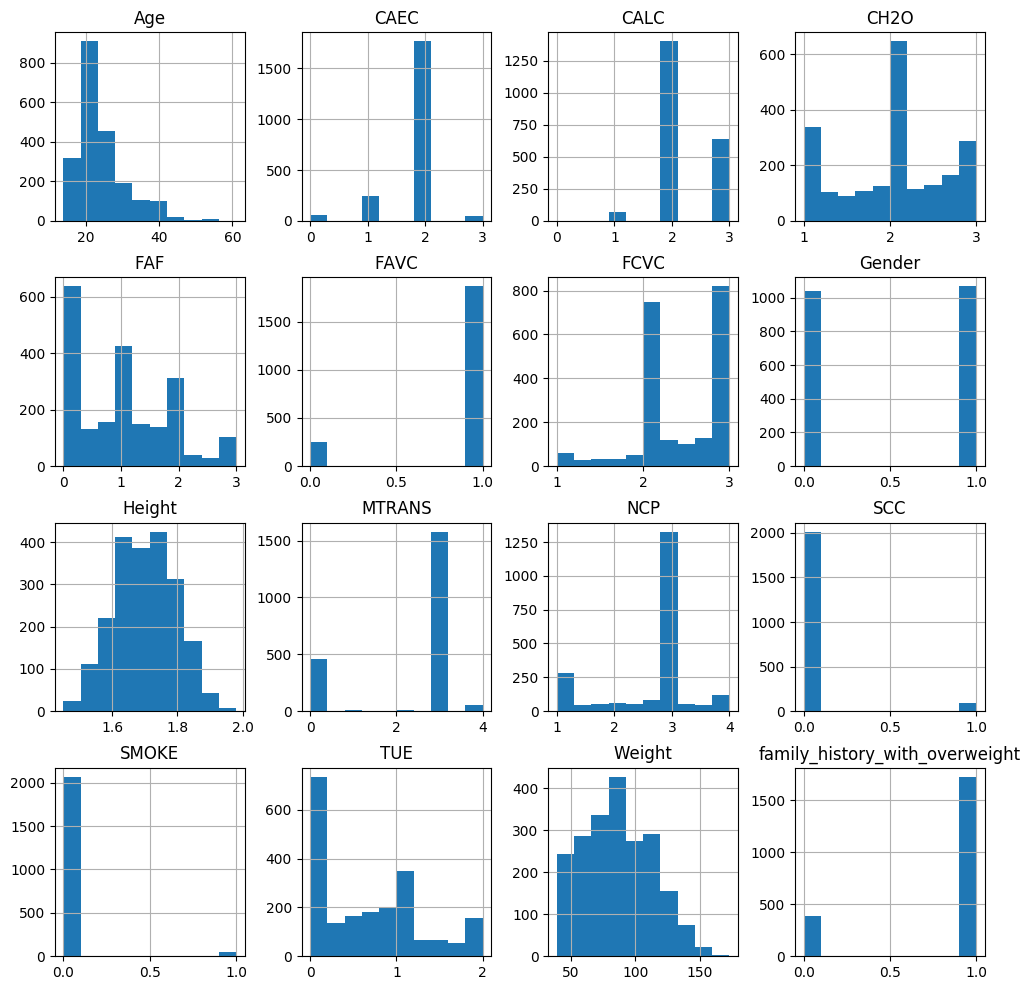

In [5]:
# draw hist for dataset
# data.hist(figsize=(12, 12))

data.iloc[:, 0:-1].hist(figsize=(12, 12))

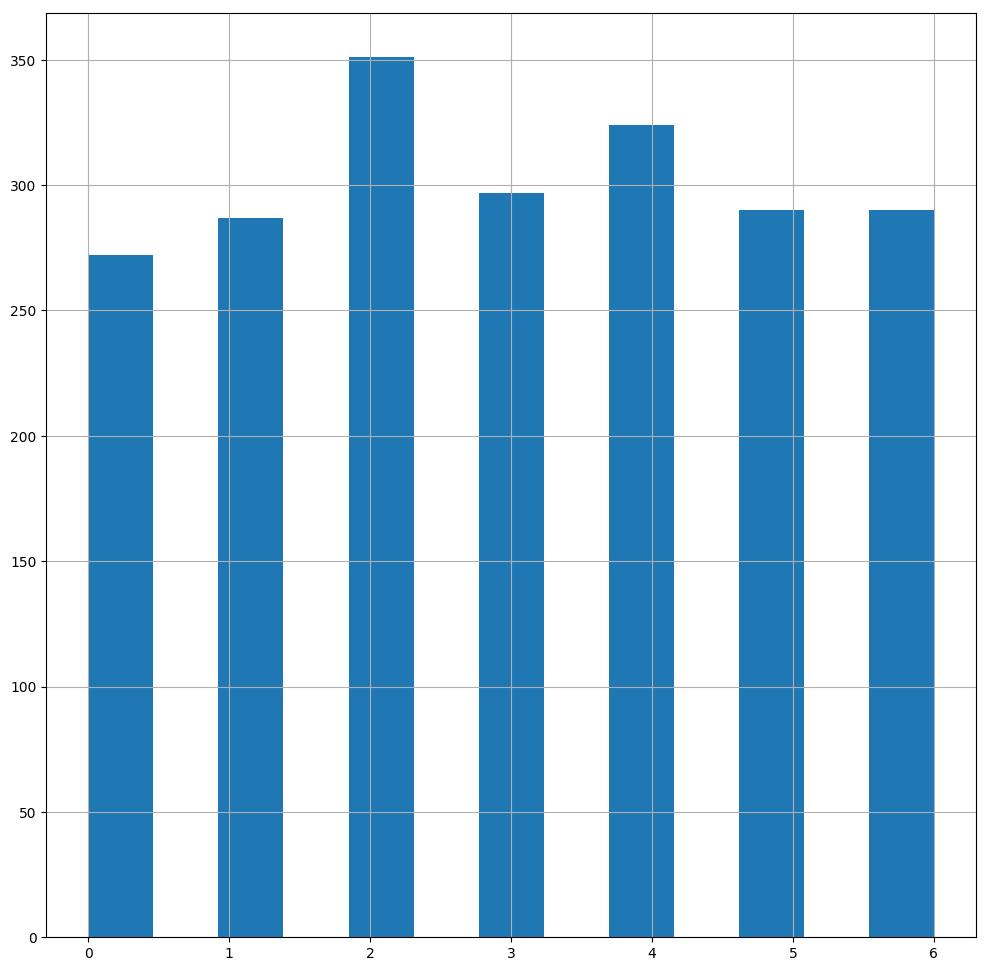

In [6]:
data.iloc[:, -1].hist(figsize=(12, 12), bins=13)


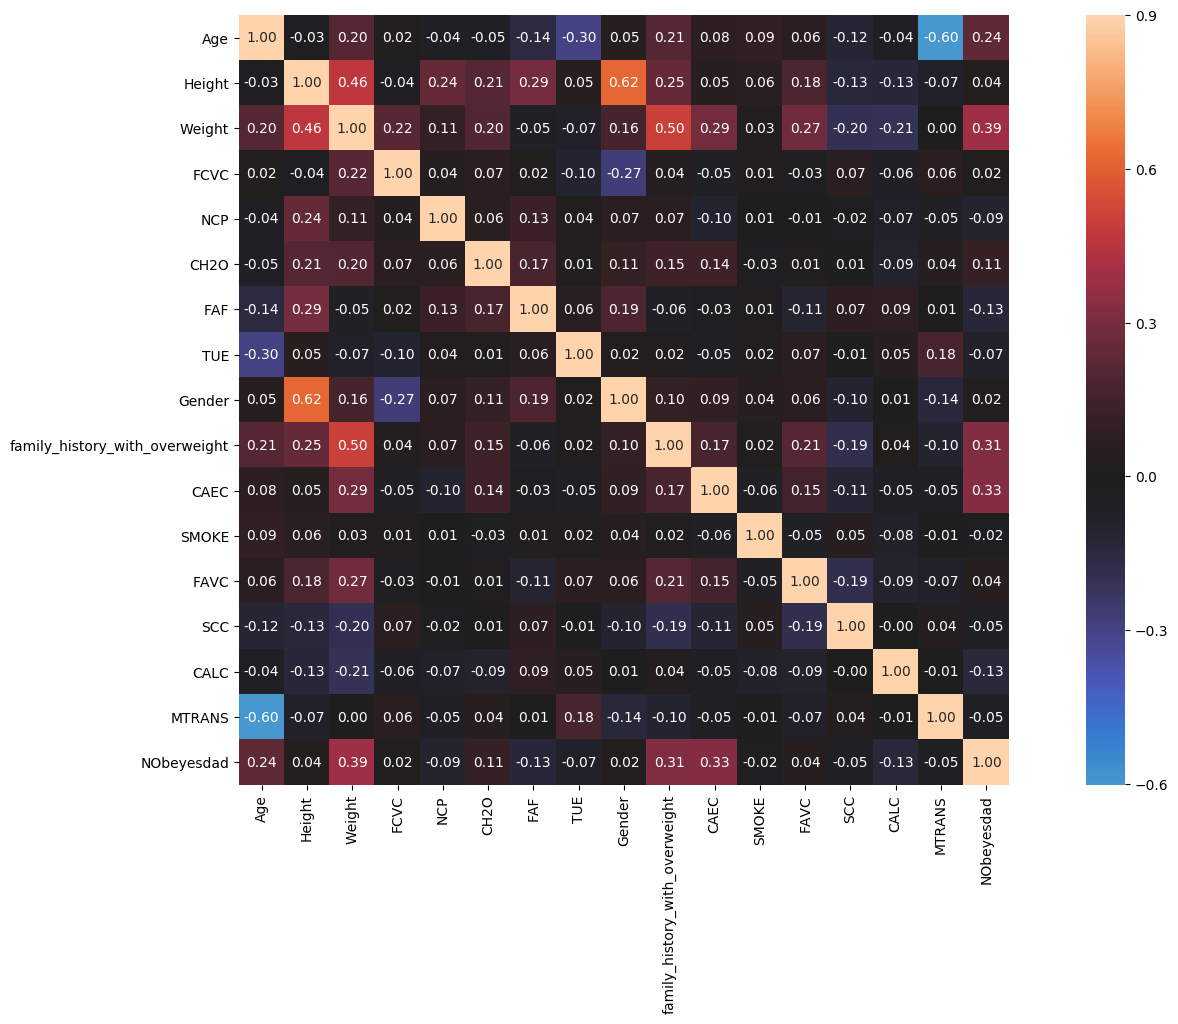

In [7]:
import seaborn as sns

plt.subplots(figsize=(20, 10))
sns.heatmap(data.corr(), vmax=.9, square=True, annot=True, fmt='.2f', center=0)
plt.show()

In [8]:
# split data
training_x, testing_x, training_y, testing_y = sklearn.model_selection.train_test_split(
features, classes, test_size=0.2, random_state=seed, stratify=classes)

In [9]:
print(training_x.shape)
print(testing_x.shape)
print(training_y.shape)
print(testing_y.shape)

(1688, 16)
(423, 16)
(1688,)
(423,)


In [10]:
from sklearn.preprocessing import StandardScaler

features = StandardScaler().fit_transform(features)
training_x = StandardScaler().fit_transform(training_x)
testing_x = StandardScaler().fit_transform(testing_x)


# Accuracy
### According to the fig above, the sample is not balanced (Death = 1 samples are significally fewer than Death = 0 samples), so we use "weighted" mode for accuracy calculating.

In [11]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.utils import compute_sample_weight

def balanced_accuracy(truth, pred):
    wts = compute_sample_weight('balanced', truth)
    return accuracy_score(truth, pred, sample_weight=wts)

# Section 1: NN

In [12]:
alphas = [10 ** -x for x in np.arange(0.0, 6.0)]    # 0.000001 - 1
d = features.shape[1]
hiddens = [(h,) * l for l in [1, 2, 3] for h in [d, d // 2, d * 2]]
learning_rate_init = [10 ** -x for x in np.arange(2.0, 6.0)]

# print(alphas)
# print(d)
# print(hiddens)
# print(learning_rates)

params = {'activation': ['relu', 'logistic'], 'alpha': alphas,
          'learning_rate_init': learning_rate_init,
          'hidden_layer_sizes': hiddens}


In [13]:
print(hiddens)

[(16,), (8,), (32,), (16, 16), (8, 8), (32, 32), (16, 16, 16), (8, 8, 8), (32, 32, 32)]


Use grid search to find best params. Take a few minutes.

In [14]:
from sklearn import neural_network
from sklearn.base import BaseEstimator

# def fit_NN_classifier(parameters, train_x, train_y, val_x, val_y)


NN_classifier = neural_network.MLPClassifier(
            hidden_layer_sizes=12,
            activation='relu',
            solver='adam',
            alpha=0.00001,
            learning_rate_init=0.00001,
)

grid_seacher = sklearn.model_selection.GridSearchCV(NN_classifier, n_jobs=4, param_grid=params, 
                                                    refit=True, verbose=10, cv=5, scoring=make_scorer(accuracy_score))
grid_fit = grid_seacher.fit(training_x, training_y)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.884272997032641, total=   0.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.8911764705882353, total=   0.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9090909090909091, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,)

[Parallel(n_jobs=4)]: Batch computation too fast (0.1585s.) Setting batch_size=2.


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9191616766467066, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.5s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8269794721407625, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8352941176470589, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8456973293768546, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8184523809523809, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4340175953079179, total=   0.6s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.5281899109792285, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.47904191616766467, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8473053892215568, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.47023809523809523, total=   0.6s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4323529411764706, total=   0.6s[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 

[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.12023460410557185, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    2.0s


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9149560117302052, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.19117647058823528, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.8931750741839762, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9205882352941176, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1488095238095238, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9434523809523809, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9161676646706587, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.13353115727002968, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.75, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.23053892215568864, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.782991202346041, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7916666666666666, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    3.4s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7685459940652819, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.2785923753665689, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.314540059347181, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.8143712574850299, total=   0.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.25748502994011974, total=   0.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.2088235294117647, total=   0.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.24107142857142858, total=   0.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.14705882352941177, total=   0.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9266862170087976, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.10850439882697947, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.1636904761904762, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9147058823529411, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.18100890207715134, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001 [CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9080118694362018, total=   0.3s

[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9221556886227545, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    4.9s


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9136904761904762, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.09880239520958084, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8676470588235294, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.873900293255132, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8690476190476191, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6070381231671554, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8635014836795252, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6231454005934718, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8772455089820359, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.55, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5958083832335329, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5327380952380952, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.16176470588235295, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.17261904761904762, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Batch computation too slow (2.0567s.) Setting batch_size=1.


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9501466275659824, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9235294117647059, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.11436950146627566, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9376854599406528, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    7.8s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.17804154302670624, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.1467065868263473, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9401197604790419, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9583333333333334, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8852941176470588, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9434523809523809, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9442815249266863, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9251497005988024, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9228486646884273, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5043988269794721, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.49117647058823527, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.56973293768546, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:    9.7s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5059523809523809, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5359281437125748, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.10263929618768329, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.17058823529411765, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9442815249266863, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9441176470588235, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.18991097922848665, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13095238095238096, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.15568862275449102, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9436201780415431, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9613095238095238, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9461077844311377, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done  83 tasks      | elapsed:   11.3s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8651026392961877, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.888235294117647, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8902077151335311, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.9077380952380952, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8922155688622755, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.34310850439882695, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.32941176470588235, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.26112759643916916, total=   0.5s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.4166666666666667, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.32335329341317365, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16129032258064516, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13529411764705881, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 

[Parallel(n_jobs=4)]: Done  94 tasks      | elapsed:   13.0s



[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9442815249266863, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1572700296735905, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.18452380952380953, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9323529411764706, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16766467065868262, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9287833827893175, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9642857142857143, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.937125748502994, total=   0.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9442815249266863, total=   1.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9294117647058824, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9347181008902077, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9494047619047619, total=   1.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 

[Parallel(n_jobs=4)]: Done 107 tasks      | elapsed:   14.9s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9341317365269461, total=   1.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6627565982404692, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6470588235294118, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6409495548961425, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6428571428571429, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.7005988023952096, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.2756598240469208, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.3, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9472140762463344, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9323529411764706, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9347181008902077, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.34718100890207715, total=   1.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   17.8s


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9523809523809523, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.30952380952380953, total=   1.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9341317365269461, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.23652694610778444, total=   1.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9530791788856305, total=   0.9s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9264705882352942, total=   0.9s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9347181008902077, total=   0.9s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9494047619047619, total=   1.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9431137724550899, total=   0.9s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.530791788856305, total=   1.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5323529411764706, total=   0.9s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5252225519287834, total=   1.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5148809523809523, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1348973607038123, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5778443113772455, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13529411764705881, total=   1.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done 135 tasks      | elapsed:   21.3s


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9530791788856305, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9441176470588235, total=   0.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9584569732937686, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.17804154302670624, total=   1.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.09226190476190477, total=   1.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.18562874251497005, total=   1.0s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9523809523809523, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.937125748502994, total=   0.2s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9120234604105572, total=   0.8s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 [CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9235294117647059, total=   0.7s

[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9258160237388724, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9226190476190477, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9461077844311377, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.2873900293255132, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.42058823529411765, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.29673590504451036, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Done 150 tasks      | elapsed:   23.8s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.43452380952380953, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.2694610778443114, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1466275659824047, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.15588235294117647, total=   0.7s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9208211143695014, total=   0.1s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.95, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1632047477744807, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16666666666666666, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1497005988023952, total=   0.8s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9376854599406528, total=   0.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9672619047619048, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.937125748502994, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9560117302052786, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9352941176470588, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9643916913946587, total=   1.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9642857142857143, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 167 tasks      | elapsed:   26.8s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9491017964071856, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7272727272727273, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7382352941176471, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7181008902077152, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7380952380952381, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7844311377245509, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.1348973607038123, total=   1.4s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.2823529411764706, total=   1.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9560117302052786, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9264705882352942, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9198813056379822, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.2195845697329377, total=   1.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.3005952380952381, total=   1.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.23652694610778444, total=   1.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9434523809523809, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9161676646706587, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 184 tasks      | elapsed:   31.5s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8504398826979472, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8411764705882353, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.798219584569733, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8392857142857143, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.36070381231671556, total=   0.6s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8413173652694611, total=   0.6s[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 

[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.36470588235294116, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4658753709198813, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.46130952380952384, total=   0.6s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 [CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.45209580838323354, total=   0.6s

[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.2991202346041056, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.17352941176470588, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.18694362017804153, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.05654761904761905, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9472140762463344, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.15868263473053892, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9347181008902077, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 [CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9382352941176471, total=   0.4s

[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 203 tasks      | elapsed:   34.1s


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9613095238095238, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9431137724550899, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.8064516129032258, total=   0.4s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 [CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7382352941176471, total=   0.4s

[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7626112759643917, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7589285714285714, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7275449101796407, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.31671554252199413, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.37058823529411766, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3115727002967359, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3502994011976048, total=   0.5s[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.38095238095238093, total=   0.5s

[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 [CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.16422287390029325, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.18235294117647058, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.1394658753709199, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.2916666666666667, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9178885630498533, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.15269461077844312, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9228486646884273, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9235294117647059, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9375, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 222 tasks      | elapsed:   36.4s


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9281437125748503, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8914956011730205, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8441176470588235, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8486646884272997, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8601190476190477, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.9041916167664671, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6217008797653959, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.611764705882353, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5548961424332344, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5595238095238095, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6137724550898204, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.22580645161290322, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.15294117647058825, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9208211143695014, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.1632047477744807, total=   0.8s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 [CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.17857142857142858, total=   0.8s

[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9235294117647059, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.18862275449101795, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9495548961424333, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9345238095238095, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9461077844311377, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 243 tasks      | elapsed:   39.8s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8973607038123167, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.913946587537092, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9196428571428571, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9011976047904192, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.4604105571847507, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5088235294117647, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5637982195845698, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5714285714285714, total=   0.9s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5329341317365269, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.3029411764705882, total=   0.8s
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1436950146627566, total=   0.9s[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 

[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9442815249266863, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9176470588235294, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.11572700296735905, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.10416666666666667, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9228486646884273, total=   0.3s[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.17365269461077845, total=   0.8s

[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9494047619047619, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9251497005988024, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:   43.4s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8797653958944281, total=   0.6s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8823529411764706, total=   0.6s[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 

[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8931750741839762, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8363095238095238, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.4222873900293255, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8952095808383234, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.31470588235294117, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3026706231454006, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.4107142857142857, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.24850299401197604, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16422287390029325, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.15, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9354838709677419, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13690476190476192, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.14836795252225518, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9235294117647059, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.10778443113772455, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9376854599406528, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9642857142857143, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9461077844311377, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9178885630498533, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9264705882352942, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 287 tasks      | elapsed:   47.2s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.913946587537092, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9464285714285714, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.937125748502994, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.7155425219941349, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6588235294117647, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6498516320474778, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6488095238095238, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6766467065868264, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.24633431085043989, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.16470588235294117, total=   1.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9501466275659824, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9205882352941176, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9020771513353115, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.2878338278931751, total=   1.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.36607142857142855, total=   1.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9345238095238095, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9341317365269461, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.27245508982035926, total=   1.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9354838709677419, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9205882352941176, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9317507418397626, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9404761904761905, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.937125748502994, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5278592375366569, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 310 tasks      | elapsed:   52.7s
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5705882352941176, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5578635014836796, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5178571428571429, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.4820359281437126, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.11143695014662756, total=   1.0s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.14705882352941177, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9442815249266863, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9235294117647059, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9317507418397626, total=   0.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.16913946587537093, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.125, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9494047619047619, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1377245508982036, total=   0.9s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.937125748502994, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9178885630498533, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9029411764705882, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9169139465875371, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.8958333333333334, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9281437125748503, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.2434017595307918, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.32941176470588235, total=   0.8s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.4836795252225519, total=   0.7s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.26785714285714285, total=   0.9s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.3143712574850299, total=   0.9s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.12609970674486803, total=   0.9s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=4)]: Done 335 tasks      | elapsed:   57.3s


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.12352941176470589, total=   0.9s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9472140762463344, total=   0.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.23738872403560832, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.11011904761904762, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9117647058823529, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.07784431137724551, total=   1.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9191616766467066, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9434523809523809, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9347181008902077, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9384

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9436201780415431, total=   1.6s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9315476190476191, total=   1.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9131736526946108, total=   1.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7008797653958945, total=   1.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7382352941176471, total=   1.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.744807121661721, total=   1.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7351190476190477, total=   1.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7365269461077845, total=   1.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.1378299120234604, total=   1.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.20294117647058824, total=   1.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9178885630498533, total=   0.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9352941176470588, total=   0.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.32047477744807124, total=   1.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done 360 tasks      | elapsed:  1.1min


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9287833827893175, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.3712574850299401, total=   1.6s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 [CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.34226190476190477, total=   1.6s

[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9375, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9101796407185628, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8147058823529412, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8123167155425219, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8605341246290801, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8125, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.844311377245509, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.44281524926686217, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.49411764705882355, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4035608308605341, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4880952380952381, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.46407185628742514, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1436950146627566, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.17647058823529413, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.09792284866468842, total=   0.7s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 [CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1875, total=   0.7s

[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9618768328445748, total=   0.5s
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.20958083832335328, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9588235294117647, total=   0.6s
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9525222551928784, total=   0.6s[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 

[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9375, total=   0.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9191616766467066, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7712609970674487, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7823529411764706, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7210682492581603, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 387 tasks      | elapsed:  1.1min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7708333333333334, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.41642228739002934, total=   0.5s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7934131736526946, total=   0.5s[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 

[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.32047477744807124, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.30357142857142855, total=   0.5s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 [CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.23652694610778444, total=   0.5s

[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.15835777126099707, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.20588235294117646, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.14540059347181009, total=   0.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.21428571428571427, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.16167664670658682, total=   0.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9354838709677419, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9198813056379822, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9294117647058824, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9315476190476191, total=   0.5s
[CV] activation=relu, alpha

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8475073313782991, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8735294117647059, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8783382789317508, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8809523809523809, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8772455089820359, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5806451612903226, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6323529411764706, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5964391691394659, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5505952380952381, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5868263473053892, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.09970674486803519, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Done 414 tasks      | elapsed:  1.2min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.15294117647058825, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9266862170087976, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.1543026706231454, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.20238095238095238, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.11377245508982035, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9088235294117647, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9221556886227545, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9494047619047619, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9317507418397626, total=   0.7s
[

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9325513196480938, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8911764705882353, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9080118694362018, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9285714285714286, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.907185628742515, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5425219941348973, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5352941176470588, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.516320474777448, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5505952380952381, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5359281437125748, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.16422287390029325, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.17941176470588235, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.967741935483871, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.24629080118694363, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9294117647058824, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13988095238095238, total=   0.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9406528189910979, total=   0.3s[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.16467065868263472, total=   0.9s

[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9191616766467066, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 443 tasks      | elapsed:  1.3min


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9464285714285714, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8441176470588235, total=   0.6s
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.873900293255132, total=   0.6s[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 

[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8456973293768546, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8511904761904762, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3812316715542522, total=   0.6s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.844311377245509, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3352941176470588, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.20474777448071216, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.32142857142857145, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.437125748502994, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.11143695014662756, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13823529411764707, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9413489736070382, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.2113095238095238, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.06231454005934718, total=   0.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1347305389221557, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9176470588235294, total=   0.4s
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9613095238095238, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 [CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9050445103857567, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9341317365269461, total=   0.4s
[

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8941176470588236, total=   1.1s
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9208211143695014, total=   1.1s[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.913946587537092, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9255952380952381, total=   1.1s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9221556886227545, total=   1.1s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.7038123167155426, total=   1.1s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6176470588235294, total=   1.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Done 472 tasks      | elapsed:  1.4min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6468842729970327, total=   1.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6279761904761905, total=   1.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6706586826347305, total=   1.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1436950146627566, total=   1.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.11470588235294117, total=   1.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9208211143695014, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9352941176470588, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.18397626112759644, total=   1.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.24404761904761904, total=   1.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9169139465875371, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.3023952095808383, total=   1.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9315476190476191, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9251497005988024, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9237536656891495, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9088235294117647, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9228486646884273, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9523809523809523, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9131736526946108, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5352941176470588, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5571847507331378, total=   1.1s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5786350148367952, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5565476190476191, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.6077844311377245, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.21114369501466276, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.12941176470588237, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9354838709677419, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9176470588235294, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9406528189910979, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1661721068249258, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9523809523809523, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.25748502994011974, total=   1.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.16964285714285715, total=   1.1s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 503 tasks      | elapsed:  1.5min


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9281437125748503, total=   0.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9264705882352942, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9237536656891495, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9169139465875371, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9345238095238095, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.907185628742515, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.15249266862170088, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.4411764705882353, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.4391691394658754, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.33630952380952384, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.2904191616766467, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.15249266862170088, total=   0.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.12941176470588237, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9090909090909091, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1437125748502994, total=   0.8s
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16023738872403562, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.13392857142857142, total=   0.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9352941176470588, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9376854599406528, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9311377245508982, total=   0.4s
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9294117647058824, total=   1.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9198813056379822, total=   1.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9251497005988024, total=   1.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7096774193548387, total=   1.4s[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7617647058823529, total=   1.4s



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 [CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7804154302670623, total=   1.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.6577380952380952, total=   1.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Done 534 tasks      | elapsed:  1.6min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.17008797653958943, total=   1.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7485029940119761, total=   1.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.22941176470588234, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9384164222873901, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.8941176470588236, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.18991097922848665, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.17261904761904762, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.1317365269461078, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9376854599406528, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9375, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9311377245508982, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8211143695014663, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8323529411764706, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.827893175074184, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8244047619047619, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8353293413173652, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.5219941348973607, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4764705882352941, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.42729970326409494, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4523809523809524, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.44011976047904194, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.14076246334310852, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.2088235294117647, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.14540059347181009, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.09821428571428571, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.12874251497005987, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9530791788856305, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9352941176470588, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9406528189910979, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9642857142857143, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9101796407185628, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7947214076246334, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7676470588235295, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7774480712166172, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 567 tasks      | elapsed:  1.7min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7648809523809523, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7455089820359282, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3313782991202346, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.2676470588235294, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.21364985163204747, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.37797619047619047, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.36227544910179643, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.1466275659824047, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.12352941176470589, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.14540059347181009, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.15178571428571427, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.19461077844311378, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9178885630498533, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9147058823529411, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9080118694362018, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9523809523809523, total=   0.6s
[CV] activation=re

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8621700879765396, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8735294117647059, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8605341246290801, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8690476190476191, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8712574850299402, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5777126099706745, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5794117647058824, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5727002967359051, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5714285714285714, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5479041916167665, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.2434017595307918, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.10882352941176471, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.0712166172106825, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.09821428571428571, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9472140762463344, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.23652694610778444, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done 600 tasks      | elapsed:  1.8min


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9147058823529411, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9614243323442137, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9523809523809523, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9341317365269461, total=   0.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8944281524926686, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8941176470588236, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9109792284866469, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9285714285714286, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9311377245508982, total=   0.9s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.45161290322580644, total=   0.9s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.538235294117647, total=   0.9s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5489614243323442, total=   0.9s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5748502994011976, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1906158357771261, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13529411764705881, total=   0.9s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9706744868035191, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.17804154302670624, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.16666666666666666, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9352941176470588, total=   0.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.2125748502994012, total=   0.9s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.8862275449101796, total=   0.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9642857142857143, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9525222551928784, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.9032258064516129, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.884272997032641, total=   0.6s
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8794117647058823, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8273809523809523, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.9131736526946108, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3812316715542522, total=   0.6s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.27647058823529413, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.40059347181008903, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.2708333333333333, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.4281437125748503, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.11436950146627566, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.12058823529411765, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done 635 tasks      | elapsed:  1.9min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1543026706231454, total=   0.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9501466275659824, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16964285714285715, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.18562874251497005, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9169139465875371, total=   0.4s[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9264705882352942, total=   0.4s

[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 [CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9434523809523809, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9281437125748503, total

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9058823529411765, total=   1.1s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 [CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9208211143695014, total=   1.1s

[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9228486646884273, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9345238095238095, total=   1.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9401197604790419, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6774193548387096, total=   1.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6882352941176471, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6676557863501483, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6369047619047619, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6826347305389222, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.31671554252199413, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.27647058823529413, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9208211143695014, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9205882352941176, total=   0.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1394658753709199, total=   1.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9376854599406528, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.19047619047619047, total=   1.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9613095238095238, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9131736526946108, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.20359281437125748, total=   1.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9472140762463344, total=   1.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9147058823529411, total=   1.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9465875370919882, total=   1.0s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 [CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9345238095238095, total=   1.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9251497005988024, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5953079178885631, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 670 tasks      | elapsed:  2.0min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.48823529411764705, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5756676557863502, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5297619047619048, total=   1.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.6317365269461078, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.11143695014662756, total=   1.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.15, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9530791788856305, total=   0.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9205882352941176, total=   0.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9406528189910979, total=   0.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.12759643916913946, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.15773809523809523, total=   1.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9226190476190477, total=   0.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1317365269461078, total=   1.1s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9191616766467066, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9296187683284457, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9058823529411765, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.8991097922848664, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9136904761904762, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9101796407185628, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.42058823529411765, total=   0.7s[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.4809384164222874, total=   0.8s

[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 [CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.39465875370919884, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.3541666666666667, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.344311377245509, total=   0.8s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.24926686217008798, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16470588235294117, total=   0.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9501466275659824, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16023738872403562, total=   0.8s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9176470588235294, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.12275449101796407, total=   0.8s
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.17261904761904762, total=   0.8s[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 

[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9080118694362018, total=   0.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9161676646706587, total=   0.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9178885630498533, total=   1.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9176470588235294, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9020771513353115, total=   1.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9464285714285714, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 707 tasks      | elapsed:  2.1min


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9131736526946108, total=   1.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7419354838709677, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7264705882352941, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7537091988130564, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7113095238095238, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7365269461077845, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.2697947214076246, total=   1.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.18529411764705883, total=   1.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9266862170087976, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.2314540059347181, total=   1.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9323529411764706, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.27380952380952384, total=   1.6s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 [CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.30538922155688625, total=   1.6s

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9317507418397626, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9375, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9191616766467066, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8328445747800587, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8323529411764706, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8130563798219584, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7886904761904762, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8502994011976048, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4838709677419355, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.45588235294117646, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.5281899109792285, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4851190476190476, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4820359281437126, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.11730205278592376, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.19705882352941176, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1513353115727003, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.13392857142857142, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1437125748502994, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9589442815249267, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9470588235294117, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.913946587537092, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9494047619047619, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9491017964071856, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7771260997067448, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:  2.3min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7823529411764706, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7626112759643917, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7916666666666666, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7604790419161677, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.31671554252199413, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.27299703264094954, total=   0.5s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.40294117647058825, total=   0.5s[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.2648809523809524, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.4281437125748503, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.1436950146627566, total=   0.5s[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.15294117647058825, total=   0.5s

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 [CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.13353115727002968, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.08928571428571429, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.11676646706586827, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9149560117302052, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9205882352941176, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9434523809523809, total=   0.5s
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9109792284866469, total=   0.6s[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV] activ

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8680351906158358, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.861764705882353, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8753709198813057, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.875, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8952095808383234, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6099706744868035, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.55, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5014836795252225, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5922619047619048, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.16715542521994134, total=   0.7s[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.625748502994012, total=   0.8s

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 [CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.2235294117647059, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.17804154302670624, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9296187683284457, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9264705882352942, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.18452380952380953, total=   0.8s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.10179640718562874, total=   0.8s[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9436201780415431, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.907185628742515, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 783 tasks      | elapsed:  2.4min


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9523809523809523, total=   0.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.906158357771261, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8647058823529412, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8961424332344213, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9136904761904762, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9281437125748503, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5249266862170088, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5117647058823529, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5905044510385756, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5208333333333334, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5568862275449101, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.14076246334310852, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.15588235294117647, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9501466275659824, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9382352941176471, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.16913946587537093, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1636904761904762, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.15868263473053892, total=   0.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9406528189910979, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9434523809523809, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.937125748502994, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8826979472140762, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8176470588235294, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8427299703264095, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8363095238095238, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8682634730538922, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.41642228739002934, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3176470588235294, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3649851632047478, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3601190476190476, total=   0.6s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3383233532934132, total=   0.6s[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13196480938416422, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.12352941176470589, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9325513196480938, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.14836795252225518, total=   0.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16964285714285715, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16467065868263472, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9323529411764706, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9285714285714286, total=   0.3s[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9317507418397626, total=   0.4s

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 [CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.92514970059880

[Parallel(n_jobs=4)]: Done 822 tasks      | elapsed:  2.5min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9354838709677419, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9080118694362018, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9117647058823529, total=   1.1s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9315476190476191, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8982035928143712, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6891495601173021, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.638235294117647, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6824925816023739, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6547619047619048, total=   1.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6646706586826348, total=   1.1s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 [CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.16715542521994134, total=   1.1s

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.21470588235294116, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9296187683284457, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9352941176470588, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9258160237388724, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.20474777448071216, total=   1.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.24404761904761904, total=   1.2s[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.15868263473053892, total=   1.2s

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 [CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9375, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9311377245508982, total=   0.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9176470588235294, total=   1.1s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9178885630498533, total=   1.1s[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9258160237388724, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9226190476190477, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9311377245508982, total=   1.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5953079178885631, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5617647058823529, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.456973293768546, total=   1.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5684523809523809, total=   1.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5179640718562875, total=   1.0s[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.23460410557184752, total=   1.0s

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 [CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13529411764705881, total=   1.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9090909090909091, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9176470588235294, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9198813056379822, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.10089020771513353, total=   1.0s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9345238095238095, total=   0.2s
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.16167664670658682, total=   1.0s

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 [CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.15476190476190477, total=   1.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 863 tasks      | elapsed:  2.7min


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9161676646706587, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9325513196480938, total=   0.8s
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9205882352941176, total=   0.8s[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.8783382789317508, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9196428571428571, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9341317365269461, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.3020527859237537, total=   0.7s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 [CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.21176470588235294, total=   0.7s

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.4332344213649852, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.7s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.32335329341317365, total=   0.7s[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 [CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.14076246334310852, total=   0.7s


[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 [CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1411764705882353, total=   0.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9208211143695014, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9088235294117647, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16071428571428573, total=   0.8s
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16467065868263472, total=   0.8s[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 

[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.142433234421365, total=   0.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9109792284866469, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9011976047904192, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9583333333333334, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9347181008902077, total=   1.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9345238095238095, total=   1.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9341317365269461, total=   1.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7478005865102639, total=   1.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7264705882352941, total=   1.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7270029673590505, total=   1.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.75, total=   1.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7634730538922155, total=   1.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.2434017595307918, total=   1.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.14705882352941177, total=   1.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9442815249266863, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.2433234421364985, total=   1.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9235294117647059, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.2619047619047619, total=   1.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.3323353293413174, total=   1.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9287833827893175, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9494047619047619, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.907185628742515, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 904 tasks      | elapsed:  2.8min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8181818181818182, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8235294117647058, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8160237388724035, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.8154761904761905, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.844311377245509, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.49560117302052786, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4294117647058823, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.486646884272997, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.36904761904761907, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4251497005988024, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.15542521994134897, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.22058823529411764, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.09523809523809523, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9560117302052786, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.2904191616766467, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9264705882352942, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9583333333333334, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9228486646884273, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9431137724550899, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7800586510263929, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7382352941176471, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7685459940652819, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.8125, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.8023952095808383, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.35777126099706746, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3798219584569733, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.39880952380952384, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.39520958083832336, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.11143695014662756, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.10089020771513353, total=   3.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.24411764705882352, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.20178041543026706, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.08928571428571429, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.24850299401197604, total=   0.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9088235294117647, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9178885630498533, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9169139465875371, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9494047619047619, total=   0.7s
[CV] activation=re

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8680351906158358, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8588235294117647, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8427299703264095, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 947 tasks      | elapsed:  2.9min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8720238095238095, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.874251497005988, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6129032258064516, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6088235294117647, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6172106824925816, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5773809523809523, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.6377245508982036, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.09970674486803519, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.20588235294117646, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.1543026706231454, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9530791788856305, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.25297619047619047, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.25748502994011974, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9205882352941176, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9554896142433235, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9494047619047619, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9251497005988024, total=

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9325513196480938, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8852941176470588, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8991097922848664, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9047619047619048, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.9131736526946108, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5425219941348973, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5235294117647059, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.4599406528189911, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5148809523809523, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.5299401197604791, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.17302052785923755, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1588235294117647, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9325513196480938, total=   0.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9058823529411765, total=   0.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.19584569732937684, total=   0.9s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.08333333333333333, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.17365269461077845, total=   0.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9376854599406528, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9553571428571429, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9221556886227545, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8709677419354839, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8411764705882353, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8902077151335311, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8541666666666666, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8532934131736527, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.34310850439882695, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3735294117647059, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Done 990 tasks      | elapsed:  3.1min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3827893175074184, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.35119047619047616, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3502994011976048, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1495601173020528, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16176470588235295, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9237536656891495, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.12759643916913946, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1488095238095238, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1407185628742515, total=   0.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9376854599406528, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9205882352941176, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9464285714285714, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9401197604790419, total=

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9176470588235294, total=   1.1s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 [CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9325513196480938, total=   1.2s

[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9287833827893175, total=   1.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9285714285714286, total=   1.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9251497005988024, total=   1.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6803519061583577, total=   1.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6588235294117647, total=   1.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.629080118694362, total=   1.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6130952380952381, total=   1.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.6946107784431138, total=   1.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.17008797653958943, total=   1.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.3, total=   1.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9296187683284457, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9088235294117647, total=   0.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9376854599406528, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.17559523809523808, total=   1.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.281437125748503, total=   1.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9494047619047619, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9251497005988024, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9266862170087976, total=   1.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9117647058823529, total=   1.1s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8931750741839762, total=   1.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9464285714285714, total=   1.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9161676646706587, total=   1.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5659824046920822, total=   1.0s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5764705882352941, total=   1.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5578635014836796, total=   1.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5535714285714286, total=   1.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.5508982035928144, total=   1.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1495601173020528, total=   1.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.25882352941176473, total=   1.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done 1035 tasks      | elapsed:  3.2min


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9530791788856305, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9323529411764706, total=   0.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9198813056379822, total=   0.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.17507418397626112, total=   1.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9375, total=   0.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.16666666666666666, total=   1.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.2275449101796407, total=   1.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9011976047904192, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9090909090909091, total=   0.8s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 [CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9088235294117647, total=   0.8s

[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.913946587537092, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9285714285714286, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.9221556886227545, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.44574780058651026, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.38529411764705884, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.23738872403560832, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.43452380952380953, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.12316715542521994, total=   0.7s[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.45808383233532934, total=   0.7s

[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.15588235294117647, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9384164222873901, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.12759643916913946, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 [CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9411764705882353, total=   0.3s

[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.22321428571428573, total=   0.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1467065868263473, total=   0.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9198813056379822, total=   0.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9281437125748503, total=   0.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9494047619047619, total=   0.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9347181008902077, total=   1.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9281437125748503, total=   1.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7800586510263929, total=   1.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7470588235294118, total=   1.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7418397626112759, total=   1.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7470238095238095, total=   1.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.7574850299401198, total=   1.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.2756598240469208, total=   1.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.2235294117647059, total=   1.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.8181818181818182, total=   0.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.8058823529411765, total=   0.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.8130563798219584, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.7857142857142857, total=   0.

[Parallel(n_jobs=4)]: Done 1080 tasks      | elapsed:  3.4min


[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.19287833827893175, total=   1.6s
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.8323353293413174, total=   0.2s[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001 

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.27380952380952384, total=   1.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.24251497005988024, total=   1.6s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7448680351906158, total=   0.6s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7058823529411765, total=   0.6s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7299703264094956, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.6845238095238095, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.3782991202346041, total=   0.6s[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7095808383233533, total=   0.7s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 [CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.43823529411764706, total=   0.6s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.42729970326409494, total=   0.6s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4226190476190476, total=   0.6s
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4311377245508982, total=   0.6s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.18529411764705883, total=   0.6s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.19941348973607037, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.8240469208211144, total=   0.2s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 [CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.13056379821958458, total=   0.6s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.13095238095238096, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.771513353115727, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.2844311377245509, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.8176470588235294, total=   0.4s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.8035714285714286, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.8203592814371258, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6627565982404692, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6411764705882353, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6765578635014837, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6101190476190477, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6526946107784432, total=   0.5s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 [CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.20234604105571846, total=   0.5s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.38529411764705884, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3827893175074184, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.16129032258064516, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.37202380952380953, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.2904191616766467, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.12058823529411765, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.18154761904761904, total=   0.4s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.06824925816023739, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.8299120234604106, total=   0.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.1497005988023952, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.8117647058823529, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.8160237388724035, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.8125, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.8323353293413174, total=   0.2s
[CV] activat

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7771260997067448, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7529411764705882, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7626112759643917, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7261904761904762, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 1127 tasks      | elapsed:  3.5min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.45161290322580644, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.781437125748503, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.49117647058823527, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4362017804154303, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.47619047619047616, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5149700598802395, total=   0.8s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 [CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.11143695014662756, total=   0.8s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.1264705882352941, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.844574780058651, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.8352941176470589, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.12759643916913946, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.24550898203592814, total=   0.8s[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.13988095238095238, total=   0.8s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 [CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 

[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.8779761904761905, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.8622754491017964, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.8100890

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.7917888563049853, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.7941176470588235, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.744807121661721, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8214285714285714, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.7964071856287425, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.1676470588235294, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.20821114369501467, total=   1.0s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.3056379821958457, total=   0.9s[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.16766467065868262, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13823529411764707, total=   0.9s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1378299120234604, total=   1.0s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1394658753709199, total=   0.9s[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.12275449101796407, total=   0.6s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 [CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 

[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.8299120234604106, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.12797619047619047, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.869047619047619

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6510263929618768, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6558823529411765, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6439169139465876, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6845238095238095, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.4s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6826347305389222, total=   0.6s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.6s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16766467065868262, total=   0.3s[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.4s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13056379821958458, total=   0.0s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 [CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.6s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16766467065868262, total=   0.0s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16470588235294117, total=   0.1s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1378299120234604, total=   0.4s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done 1174 tasks      | elapsed:  3.6min


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.8680351906158358, total=   0.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.8705882352941177, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 [CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.8219584569732937, total=   0.3s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.8125, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.17261904761904762, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.8233532934131736, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8533724340175953, total=   1.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8382352941176471, total=   1.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.7833827893175074, total=   1.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8482142857142857, total=   1.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8263473053892215, total=   1.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3460410557184751, total=   1.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.314540059347181, total=   1.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.31176470588235294, total=   1.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.33630952380952384, total=   1.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.39221556886227543, total=   1.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.13823529411764707, total=   1.3s[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.16715542521994134, total=   1.3s

[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 [CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 

[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.15249266862170088, total=   0.1s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.16470588235294117, total=   0.1s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_r

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1394658753709199, total=   1.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.16666666666666666, total=   1.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1347305389221557, total=   1.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.16470588235294117, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.1661721068249258, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.16666666666666666, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 1

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13056379821958458, total=   1.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.16766467065868262, total=   0.1s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 1223 tasks      | elapsed:  3.8min


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.16715542521994134, total=   0.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.16470588235294117, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.1661721068249258, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.16666666666666666, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.12874251497005987, total=   1.2s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.16766467065868262, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.15249266862170088, total=   0.8s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16715542521994134, total=   1.0s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.16470588235294117, total=   0.4s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.16715542521994134, total=   0.6s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.1661721068249258, total=   0.5s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16715542521994134, total=   1.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16470588235294117, total=   1.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.1661721068249258, total=   1.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16666666666666666, total=   1.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16766467065868262, total=   1.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16715542521994134, total=   1.7s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.13823529411764707, total=   1.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.13056379821958458, total=   1.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9442815249266863, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9117647058823529, total=   0.7s
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16666666666666666, total=   1.2s[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 

[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9287833827893175, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9404761904761905, total=   0.7s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.1377245508982036, total=   1.8s[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9161676646706587, total=   0.7s

[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 [CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.718475073313783, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.6852941176470588, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.6875, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7210682492581603, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7485029940119761, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.3782991202346041, total=   0.7s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.47352941176470587, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4035608308605341, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:  3.9min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4642857142857143, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.44610778443113774, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.16715542521994134, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.17352941176470588, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1513353115727003, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9325513196480938, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.12202380952380952, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.20958083832335328, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.8970588235294118, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9109792284866469, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9196428571428571, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9191616766467066, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6715542521994134, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6411764705882353, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7002967359050445, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6517857142857143, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6526946107784432, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.4222873900293255, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3764705882352941, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3620178041543027, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.19648093841642228, total=   0.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.17507418397626112, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.2916666666666667, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.16470588235294117, total=   0.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.23652694610778444, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.12797619047619047, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9325513196480938, total=   0.4s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.20658682634730538, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9323529411764706, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9258160237388724, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9251497005988024, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9434523809523809, total=   0.7s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7771260997067448, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7558823529411764, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7685459940652819, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7440476190476191, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8053892215568862, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.45161290322580644, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4235294117647059, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.47181008902077154, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4583333333333333, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5149700598802395, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.1378299120234604, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.22058823529411764, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.16913946587537093, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9648093841642229, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.09821428571428571, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.15269461077844312, total=   1.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9176470588235294, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9702380952380952, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9495548961424333, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 1323 tasks      | elapsed:  4.1min


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9491017964071856, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8357771260997068, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8441176470588235, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8486646884272997, total=   1.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8244047619047619, total=   1.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8233532934131736, total=   1.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.17595307917888564, total=   1.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.20294117647058824, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.4035608308605341, total=   1.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.3125, total=   1.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.15249266862170088, total=   0.9s[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.3413173652694611, total=   1.0s

[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.18263473053892215, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13690476190476192, total=   0.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13823529411764707, total=   1.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.08902077151335312, total=   1.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9470588235294117, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9560117302052786, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9287833827893175, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9583333333333334, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9311377245508982, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7565982404692082, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8264705882352941, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6973293768545994, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7142857142857143, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7215568862275449, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.15835777126099707, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.19117647058823528, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.31750741839762614, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.1377245508982036, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.15476190476190477, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1347305389221557, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.12903225806451613, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13649851632047477, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13529411764705881, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9648093841642229, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9411764705882353, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9672619047619048, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.943620

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9120234604105572, total=   1.4s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8516320474777448, total=   1.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8941176470588236, total=   1.4s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8988095238095238, total=   1.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8892215568862275, total=   1.4s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.4252199413489736, total=   1.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.34411764705882353, total=   1.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.4035608308605341, total=   1.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3958333333333333, total=   1.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Done 1374 tasks      | elapsed:  4.3min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.4251497005988024, total=   1.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1378299120234604, total=   1.4s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.16470588235294117, total=   1.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9384164222873901, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.14836795252225518, total=   1.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.15476190476190477, total=   1.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.16766467065868262, total=   1.4s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9294117647058824, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9672619047619048, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9614243323442137, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), lear

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8885630498533724, total=   1.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8735294117647059, total=   1.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8961424332344213, total=   1.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9107142857142857, total=   1.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8682634730538922, total=   1.3s[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.5s[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.5s


[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 [CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 [CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.16470588235294117, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.15249266862170088, total=   1.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1407185628742515, total=   1.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9470588235294117, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.8958333333333334, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9584569732937686, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7448680351906158, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7411764705882353, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7388724035608308, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.49404761904761907, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7395209580838323, total=   0.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.14076246334310852, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.15294117647058825, total=   0.4s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1378299120234604, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.13649851632047477, total=   0.9s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9525222551928784, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9464285714285714, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9341317365269461, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9296187683284457, total=   1.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9264705882352942, total=   1.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9406528189910979, total=   1.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 1427 tasks      | elapsed:  4.4min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9255952380952381, total=   1.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.5s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9311377245508982, total=   2.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.15476190476190477, total=   0.4s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.1378299120234604, total=   1.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.13823529411764707, total=   1.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9384164222873901, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9411764705882353, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.15269461077844312, total=   1.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9436201780415431, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9434523809523809, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9341317365269461, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7419354838709677, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.6794117647058824, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7329376854599406, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.6845238095238095, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7425149700598802, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.3764705882352941, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001 [CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.41055718475073316, total=   0.7s

[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4391691394658754, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4226190476190476, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4550898203592814, total=   0.7s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.16715542521994134, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.15294117647058825, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.13649851632047477, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.17857142857142858, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1467065868263473, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9266862170087976, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.8852941176470588, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9109792284866469, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9494047619047619, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9251497005988024, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.7038123167155426, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6705882352941176, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.685459940652819, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6160714285714286, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6646706586826348, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.36950146627565983, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3352941176470588, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3264094955489614, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.35119047619047616, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.25748502994011974, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.15249266862170088, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.1676470588235294, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.13649851632047477, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.15269461077844312, total=   0.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.15773809523809523, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done 1480 tasks      | elapsed:  4.6min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9560117302052786, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9376854599406528, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9294117647058824, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9434523809523809, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9251497005988024, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7529411764705882, total=   0.8s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8123167155425219, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7804154302670623, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7559523809523809, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8143712574850299, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4809384164222874, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4470588235294118, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5222551928783383, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.45535714285714285, total=   0.8s[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.49700598802395207, total=   0.8s

[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 [CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.12609970674486803, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.16470588235294117, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.20178041543026706, total=   0.8s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 [CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.15773809523809523, total=   0.9s

[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.11676646706586827, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9706744868035191, total=   1.0s[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.973293768545994, total=   0.8s

[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 [CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.961764705882353, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9613095238095238, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8240469208211144, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9431137724550899, total=   1.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8264705882352941, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8071216617210683, total=   1.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8303571428571429, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8263473053892215, total=   1.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.2903225806451613, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.3588235294117647, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.27002967359050445, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.17261904761904762, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.3083832335329341, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1378299120234604, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.16766467065868262, total=   0.4s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13823529411764707, total=   1.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13690476190476192, total=   1.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9501466275659824, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9294117647058824, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9523809523809523, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9376854599406528, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9520958083832335, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7360703812316716, total=   0.7s
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6911764705882353, total=   0.7s[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 

[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6973293768545994, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6994047619047619, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.18181818181818182, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.29411764705882354, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.3086053412462908, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.15773809523809523, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16766467065868262, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.12941176470588237, total=   0.5s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1378299120234604, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.12797619047619047, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.15269461077844312, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13056379821958458, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


[Parallel(n_jobs=4)]: Done 1535 tasks      | elapsed:  4.8min


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9643916913946587, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9382352941176471, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9530791788856305, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9461077844311377, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 

[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8885630498533724, total=   1.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.888235294117647, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.884272997032641, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9107142857142857, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9131736526946108, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.41642228739002934, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3411764705882353, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.4362017804154303, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.47023809523809523, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.16715542521994134, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.4550898203592814, total=   1.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1411764705882353, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.13988095238095238, total=   1.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9618768328445748, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9294117647058824, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9584569732937686, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.15269461077844312, total=   1.4s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9553571428571429, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9461077844311377, total=   1.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8944281524926686, total=   1.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8911764705882353, total=   1.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9050445103857567, total=   1.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8839285714285714, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8862275449101796, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13529411764705881, total=   0.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_size

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16766467065868262, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1378299120234604, total=   1.3s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.12797619047619047, total=   1.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9530791788856305, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.12874251497005987, total=   1.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9352941176470588, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9495548961424333, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9434523809523809, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_i

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.6598240469208211, total=   0.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.45294117647058824, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7359050445103857, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.3869047619047619, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.6646706586826348, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 1590 tasks      | elapsed:  5.0min


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.15294117647058825, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1378299120234604, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.1543026706231454, total=   0.6s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16470588235294117, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_ra

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.13649851632047477, total=   0.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9614243323442137, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9642857142857143, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9341317365269461, total=   1.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9472140762463344, total=   1.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9235294117647059, total=   1.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9495548961424333, total=   1.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9613095238095238, total=   1.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.4s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9161676646706587, total=   1.9s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.3029411764705882, total=   1.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.31750741839762614, total=   1.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.15249266862170088, total=   1.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.32335329341317365, total=   1.8s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.15294117647058825, total=   1.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.13056379821958458, total=   1.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.13690476190476192, total=   1.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16766467065868262, total=   1.7s
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9413489736070382, total=   0.7s[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 

[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9205882352941176, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9228486646884273, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9226190476190477, total=   0.7s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9311377245508982, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7272727272727273, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7147058823529412, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7388724035608308, total=   0.7s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 [CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7113095238095238, total=   0.7s

[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7425149700598802, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.436950146627566, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4323529411764706, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.3916913946587537, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4523809523809524, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.5, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.15249266862170088, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.12941176470588237, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.21068249258160238, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.16071428571428573, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9266862170087976, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.10179640718562874, total=   0.8s[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9264705882352942, total=   0.6s

[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01 [CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 



/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9050445103857567, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9434523809523809, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.937125748502994, total=   0.5s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 [CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6392961876832844, total=   0.6s

[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6529411764705882, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6706231454005934, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6369047619047619, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6616766467065869, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 1647 tasks      | elapsed:  5.2min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3343108504398827, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.35294117647058826, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3086053412462908, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.30654761904761907, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.16470588235294117, total=   0.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3143712574850299, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.16715542521994134, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.18991097922848665, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.12797619047619047, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.15269461077844312, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9589442815249267, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9352941176470588, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9228486646884273, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9613095238095238, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9221556886227545, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7741935483870968, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7529411764705882, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7804154302670623, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7380952380952381, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7934131736526946, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.45161290322580644, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4588235294117647, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4658753709198813, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4642857142857143, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5209580838323353, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.12316715542521994, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.29411764705882354, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.17804154302670624, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.13988095238095238, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.2634730538922156, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9501466275659824, total=   1.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9436201780415431, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 [CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9235294117647059, total=   0.9s

[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.782991202346041, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8441176470588235, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.798219584569733, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8363095238095238, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8293413173652695, total=   0.9s

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.36656891495601174, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.3352941176470588, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.31750741839762614, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.3125, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.3263473053892216, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.15476190476190477, total=   0.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1348973607038123, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.2314540059347181, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.15294117647058825, total=   1.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9442815249266863, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1377245508982036, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9176470588235294, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9406528189910979, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9583333333333334, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9311377245508982, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 1704 tasks      | elapsed:  5.4min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7272727272727273, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6882352941176471, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7151335311572701, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7291666666666666, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.4s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7305389221556886, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.14076246334310852, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.16470588235294117, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.27002967359050445, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1394658753709199, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.24107142857142858, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16766467065868262, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13690476190476192, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1377245508982036, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9618768328445748, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9703264094955489, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9441176470588235, total=   1.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9058823529411765, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.906158357771261, total=   1.4s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8961424332344213, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9166666666666666, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.39002932551319647, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9011976047904192, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.38235294117647056, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.4362017804154303, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3532934131736527, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.4255952380952381, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.12903225806451613, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1676470588235294, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1636904761904762, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1377245508982036, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9472140762463344, total=   1.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9673590504451038, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9470588235294117, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(1

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8826979472140762, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8823529411764706, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.887240356083086, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9017857142857143, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8832335329341318, total=   1.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13823529411764707, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16766467065868262, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1378299120234604, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9354838709677419, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1347305389221557, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9554896142433235, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9323529411764706, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9494047619047619, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 1763 tasks      | elapsed:  5.6min


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9401197604790419, total=   0.6s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7067448680351907, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7411764705882353, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.8011869436201781, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7797619047619048, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.13823529411764707, total=   0.4s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.5419161676646707, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1661721068249258, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.1377245508982036, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16766467065868262, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16715542521994134, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.13823529411764707, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.13690476190476192, total=   0.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9529411764705882, total=   0.5s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.967741935483871, total=   0.9s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 [CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9703264094955489, total=   0.6s

[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9296187683284457, total=   1.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9235294117647059, total=   1.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9406528189910979, total=   1.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9404761904761905, total=   1.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.937125748502994, total=   1.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.36363636363636365, total=   1.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.3205882352941177, total=   1.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.34124629080118696, total=   1.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.7s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16715542521994134, total=   1.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.38622754491017963, total=   1.8s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16470588235294117, total=   1.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9413489736070382, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9147058823529411, total=   0.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.13690476190476192, total=   1.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16766467065868262, total=   1.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9317507418397626, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9434523809523809, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.937125748502994, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7390029325513197, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.711764705882353, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7388724035608308, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.6964285714285714, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7365269461077845, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.39882697947214074, total=   0.7s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4147058823529412, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4391691394658754, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.48214285714285715, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.5, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1378299120234604, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.13529411764705881, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.14836795252225518, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.19642857142857142, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.17065868263473055, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9354838709677419, total=   0.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9088235294117647, total=   0.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9228486646884273, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9136904761904762, total=   0.6s

[Parallel(n_jobs=4)]: Done 1822 tasks      | elapsed:  5.9min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.937125748502994, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6832844574780058, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6411764705882353, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6706231454005934, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6607142857142857, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.655688622754491, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3724340175953079, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3176470588235294, total=   0.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.35311572700296734, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.18475073313782991, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.32142857142857145, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.1572700296735905, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.17352941176470588, total=   0.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3592814371257485, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.14285714285714285, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.11077844311377245, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9384164222873901, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9235294117647059, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9258160237388724, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001 
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9553571428571429, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9251497005988024, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7917888563049853, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7529411764705882, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7626112759643917, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7619047619047619, total=   1.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8173652694610778, total=   1.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4838709677419355, total=   1.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.46176470588235297, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5103857566765578, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5508982035928144, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.47023809523809523, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.1466275659824047, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.13823529411764707, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.2166172106824926, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.16071428571428573, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.18562874251497005, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9501466275659824, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9235294117647059, total=   0.9s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.973293768545994, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9523809523809523, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.937125748502994, total=   1.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.85, total=   1.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8563049853372434, total=   1.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8071216617210683, total=   1.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8482142857142857, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8323353293413174, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.39002932551319647, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.29411764705882354, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.2166172106824926, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.33035714285714285, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.2275449101796407, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.15249266862170088, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.15476190476190477, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.12941176470588237, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13056379821958458, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9618768328445748, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1407185628742515, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9176470588235294, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9525222551928784, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


[Parallel(n_jobs=4)]: Done 1883 tasks      | elapsed:  6.1min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9404761904761905, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9221556886227545, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.6920821114369502, total=   0.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.788235294117647, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7062314540059347, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.8065476190476191, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7874251497005988, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.2697947214076246, total=   0.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.13649851632047477, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13529411764705881, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16964285714285715, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13690476190476192, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.1347305389221557, total=   0.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1347305389221557, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.12903225806451613, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13649851632047477, total=   0.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9648093841642229, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9176470588235294, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9643916913946587, total=   1.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rat

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9002932551319648, total=   1.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8911764705882353, total=   1.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.887240356083086, total=   1.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9136904761904762, total=   1.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8952095808383234, total=   1.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3870967741935484, total=   1.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3764705882352941, total=   1.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3916913946587537, total=   1.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3869047619047619, total=   1.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3562874251497006, total=   1.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.12903225806451613, total=   1.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1588235294117647, total=   1.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1543026706231454, total=   1.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.15269461077844312, total=   0.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9560117302052786, total=   0.9s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.13988095238095238, total=   1.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9323529411764706, total=   1.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9494047619047619, total=   0.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9554896142433235, total=   1.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8504398826979472, total=   1.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8794117647058823, total=   1.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.887240356083086, total=   1.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.875, total=   1.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8652694610778443, total=   1.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16715542521994134, total=   1.2s
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16766467065868262, total=   0.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16666666666666666, total=   1.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.16715542521994134, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.12941176470588237, total=   1.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13056379821958458, total=   1.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1377245508982036, total=   1.1s[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.12797619047619047, total=   1.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 

[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.95, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9589442815249267, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_

[Parallel(n_jobs=4)]: Done 1944 tasks      | elapsed:  6.3min


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.8922155688622755, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.6920821114369502, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7264705882352941, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7210682492581603, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.6815476190476191, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7035928143712575, total=   0.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.12903225806451613, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16470588235294117, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8,

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9296187683284457, total=   1.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9323529411764706, total=   1.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9317507418397626, total=   1.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9553571428571429, total=   1.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16766467065868262, total=   0.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9221556886227545, total=   1.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.2903225806451613, total=   1.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.2916666666666667, total=   1.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16715542521994134, total=   1.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.12941176470588237, total=   1.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.1394658753709199, total=   1.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16666666666666666, total=   1.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9442815249266863, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9382352941176471, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9198813056379822, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16167664670658682, total=   1.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9375, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.01, score=0.9341317365269461, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7331378299120235, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.6882352941176471, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7329376854599406, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.6964285714285714, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.001, score=0.7455089820359282, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.39882697947214074, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.36764705882352944, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4362017804154303, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4523809523809524, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=0.0001, score=0.4491017964071856, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1348973607038123, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.15588235294117647, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.1394658753709199, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.13690476190476192, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16,), learning_rate_init=1e-05, score=0.15868263473053892, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9178885630498533, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9411764705882353, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9050445103857567, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9434523809523809, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.01, score=0.9401197604790419, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6422287390029325, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6882352941176471, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6824925816023739, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6339285714285714, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


[Parallel(n_jobs=4)]: Done 2007 tasks      | elapsed:  6.5min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.001, score=0.6676646706586826, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.2844574780058651, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.38823529411764707, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.27596439169139464, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.3601190476190476, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=0.0001, score=0.30538922155688625, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.12316715542521994, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.1323529411764706, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.12275449101796407, total=   0.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.16666666666666666, total=   0.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8,), learning_rate_init=1e-05, score=0.26112759643916916, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9560117302052786, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9382352941176471, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9347181008902077, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9375, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.01, score=0.9341317365269461, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.8005865102639296, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7558823529411764, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7893175074183977, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.7619047619047619, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.001, score=0.811377245508982, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5278592375366569, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.45294117647058824, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.5133531157270029, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.4523809523809524, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=0.0001, score=0.47604790419161674, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.14076246334310852, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.1676470588235294, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.1543026706231454, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.13392857142857142, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32,), learning_rate_init=1e-05, score=0.23053892215568864, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9560117302052786, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9411764705882353, total=   1.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9465875370919882, total=   1.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9464285714285714, total=   1.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.01, score=0.9431137724550899, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8211143695014663, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8529411764705882, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8189910979228486, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8690476190476191, total=   1.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.001, score=0.8323353293413174, total=   1.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.26099706744868034, total=   1.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.28823529411764703, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1466275659824047, total=   0.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13529411764705881, total=   0.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.41839762611275966, total=   1.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.31547619047619047, total=   1.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=0.0001, score=0.32335329341317365, total=   1.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13056379821958458, total=   1.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.13690476190476192, total=   1.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9413489736070382, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16), learning_rate_init=1e-05, score=0.1377245508982036, total=   1.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9205882352941176, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9376854599406528, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9434523809523809, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.01, score=0.9431137724550899, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.782991202346041, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.711764705882353, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7537091988130564, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7976190476190477, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.001, score=0.7275449101796407, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


[Parallel(n_jobs=4)]: Done 2070 tasks      | elapsed:  6.7min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1411764705882353, total=   0.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1394658753709199, total=   0.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.13690476190476192, total=   0.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.15476190476190477, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=0.0001, score=0.23353293413173654, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.1378299120234604, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8), learning_rate_init=1e-05, score=0.12874251497005987, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9442815249266863, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9323529411764706, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.01, score=0.9614243323442137, total=   1.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8914956011730205, total=   1.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8970588235294118, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8902077151335311, total=   1.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.9255952380952381, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.001, score=0.8922155688622755, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3812316715542522, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3911764705882353, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.42433234421364985, total=   1.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.35119047619047616, total=   1.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=0.0001, score=0.3413173652694611, total=   1.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.16715542521994134, total=   1.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.12941176470588237, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.13988095238095238, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32), learning_rate_init=1e-05, score=0.1377245508982036, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9472140762463344, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9554896142433235, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01, score=0.9323529411764706, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(1

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8856304985337243, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8676470588235294, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9198813056379822, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.9136904761904762, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.1543026706231454, total=   0.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.001, score=0.8712574850299402, total=   1.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16666666666666666, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1543026706231454, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.0001, score=0.16766467065868262, total=   1.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.1348973607038123, total=   1.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.16766467065868262, total=   0.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13529411764705881, total=   1.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9472140762463344, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9441176470588235, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(16, 16, 16), learning_rate_init=1e-05, score=0.13690476190476192, total=   1.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9169139465875371, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9131736526946108, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.01, score=0.9434523809523809, total=   0.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.6744868035190615, total=   0.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7382352941176471, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7388724035608308, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.7648809523809523, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.1661721068249258, total=   0.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.001, score=0.49700598802395207, total=   0.8s
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.8s[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 

[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.1411764705882353, total=   0.4s[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.0001, score=0.13690476190476192, total=   0.7s

[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 [CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05 

[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), l

[Parallel(n_jobs=4)]: Done 2135 tasks      | elapsed:  7.0min
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(8, 8, 8), learning_rate_init=1e-05, score=0.16715542521994134, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.973293768545994, total=   0.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9352941176470588, total=   0.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.01, score=0.9583333333333334, total=   0.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9325513196480938, total=   1.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9382352941176471, total=   1.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16715542521994134, total=   0.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.913946587537092, total=   1.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.16470588235294117, total=   0.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.9434523809523809, total=   1.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.001, score=0.937125748502994, total=   1.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.36795252225519287, total=   1.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.35714285714285715, total=   1.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.15249266862170088, total=   0.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.0001, score=0.38622754491017963, total=   1.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.1377245508982036, total=   0.3s
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.12941176470588237, total=   1.4s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.13649851632047477, total=   1.7s


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), learning_rate_init=1e-05, score=0.16666666666666666, total=   1.6s


[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed:  7.1min finished


In [18]:
train_means = grid_fit.cv_results_['mean_train_score']
train_stds = grid_fit.cv_results_['std_train_score']
test_means = grid_fit.cv_results_['mean_test_score']
test_stds = grid_fit.cv_results_['std_test_score']

print("Results for different params")
for train_mean, train_std, test_mean, test_std, params in \
    zip(train_means, train_stds, test_means, test_stds, grid_fit.cv_results_['params']):
    print("train: %0.3f (+/-%0.3f); test: %0.3f (+/-%0.3f) for %r" \
              %(train_mean, train_std*2, test_mean, test_std*2, params))

Results for different params
train: 0.951 (+/-0.015); test: 0.909 (+/-0.040) for {'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.01}
train: 0.875 (+/-0.024); test: 0.835 (+/-0.022) for {'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001}
train: 0.473 (+/-0.033); test: 0.469 (+/-0.070) for {'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.0001}
train: 0.164 (+/-0.075); test: 0.165 (+/-0.081) for {'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': (16,), 'learning_rate_init': 1e-05}
train: 0.942 (+/-0.008); test: 0.918 (+/-0.032) for {'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.01}
train: 0.802 (+/-0.031); test: 0.781 (+/-0.043) for {'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': (8,), 'learning_rate_init': 0.001}
train: 0.277 (+/-0.043); test: 0.260 (+/-0.071) for {'activation': 'relu', 'alpha': 1.0, 'hi

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


# Results on training set

In [19]:
best_estimator = grid_fit.best_estimator_
best_estimator.fit(training_x, training_y)

training_y_pred = best_estimator.predict(training_x)

print("Model performance on training set")
print("----------------")
print("Final balanced accuracy score on the training data: {:.4f}".format(balanced_accuracy(training_y, training_y_pred)))
print("Final accuracy score on the training data: {:.4f}".format(accuracy_score(training_y, training_y_pred)))
print("Final precision score on training data: {:.4f}".format(precision_score(training_y, training_y_pred, average="micro")))
print("Final recall score on training data: {:.4f}".format(recall_score(training_y, training_y_pred, average="micro")))
# print("Final ROC AUC score on training data: {:.4f}".format(roc_auc_score(training_y, training_y_pred)))
print("\n")
print("The best parameters are: {}".format(best_estimator))


Model performance on training set
----------------
Final balanced accuracy score on the training data: 0.9988
Final accuracy score on the training data: 0.9988
Final precision score on training data: 0.9988
Final recall score on training data: 0.9988


The best parameters are: MLPClassifier(activation='logistic', alpha=0.01, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16, 16), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


# Results on testing set

In [20]:
testing_y_pred = best_estimator.predict(testing_x)

print("Model performance on testing set")
print("----------------")
print("Final balanced accuracy score on the testing data: {:.4f}".format(balanced_accuracy(testing_y, testing_y_pred)))
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(testing_y, testing_y_pred)))
print("Final precision score on testing data: {:.4f}".format(precision_score(testing_y, testing_y_pred, average="micro")))
print("Final recall score on testing data: {:.4f}".format(recall_score(testing_y, testing_y_pred, average="micro")))
# print("Final ROC AUC score on testing data: {:.4f}".format(roc_auc_score(testing_y, testing_y_pred)))


Model performance on testing set
----------------
Final balanced accuracy score on the testing data: 0.9594
Final accuracy score on the testing data: 0.9598
Final precision score on testing data: 0.9598
Final recall score on testing data: 0.9598


# Confusion Matrix for testing set

Text(0.5,110.486,'Predicted label')

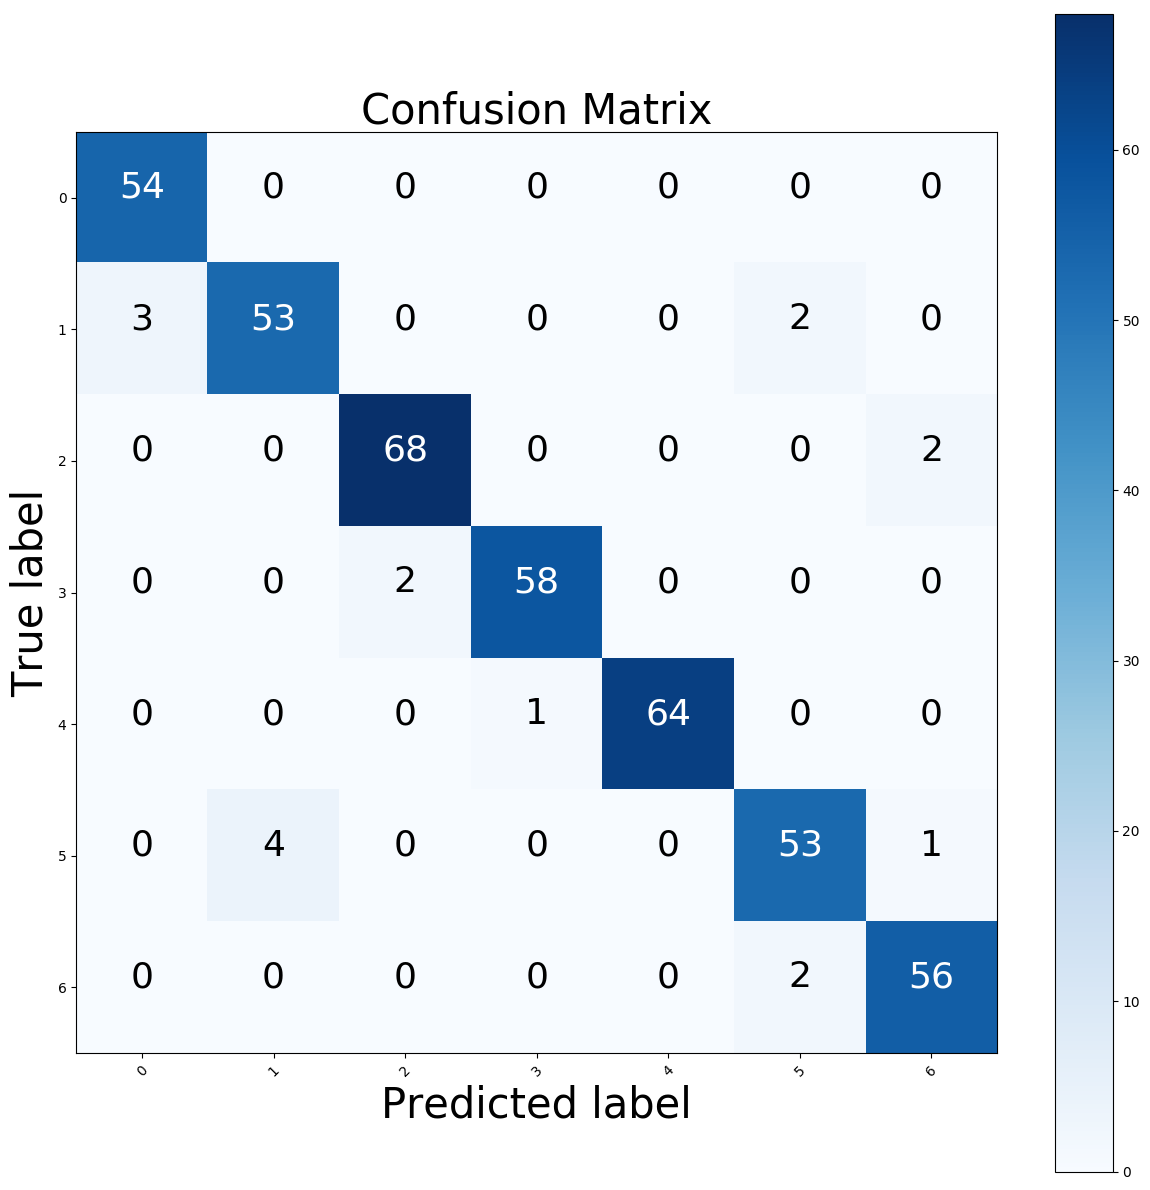

In [25]:
from sklearn.metrics import confusion_matrix

# calculate
confusion_matrix = confusion_matrix(testing_y, testing_y_pred)
normed_confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
num_classes = np.unique(classes)

cmap=plt.cm.Blues
plt.close()
plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix', fontsize=30)
plt.colorbar()
tick_marks = np.arange(len(num_classes))
plt.xticks(tick_marks, num_classes, rotation=45)
plt.yticks(tick_marks, num_classes)
plt.tight_layout()

fmt = 'd'
thresh = confusion_matrix.max() / 2.0

for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, format(confusion_matrix[i, j], fmt),
             horizontalalignment="center",
             color='white' if confusion_matrix[i, j] > thresh else "black",
            size=26)


plt.tight_layout()
plt.ylabel('True label', fontsize=30)
plt.xlabel('Predicted label', fontsize=30)





Text(0.5,109.486,'Predicted label')

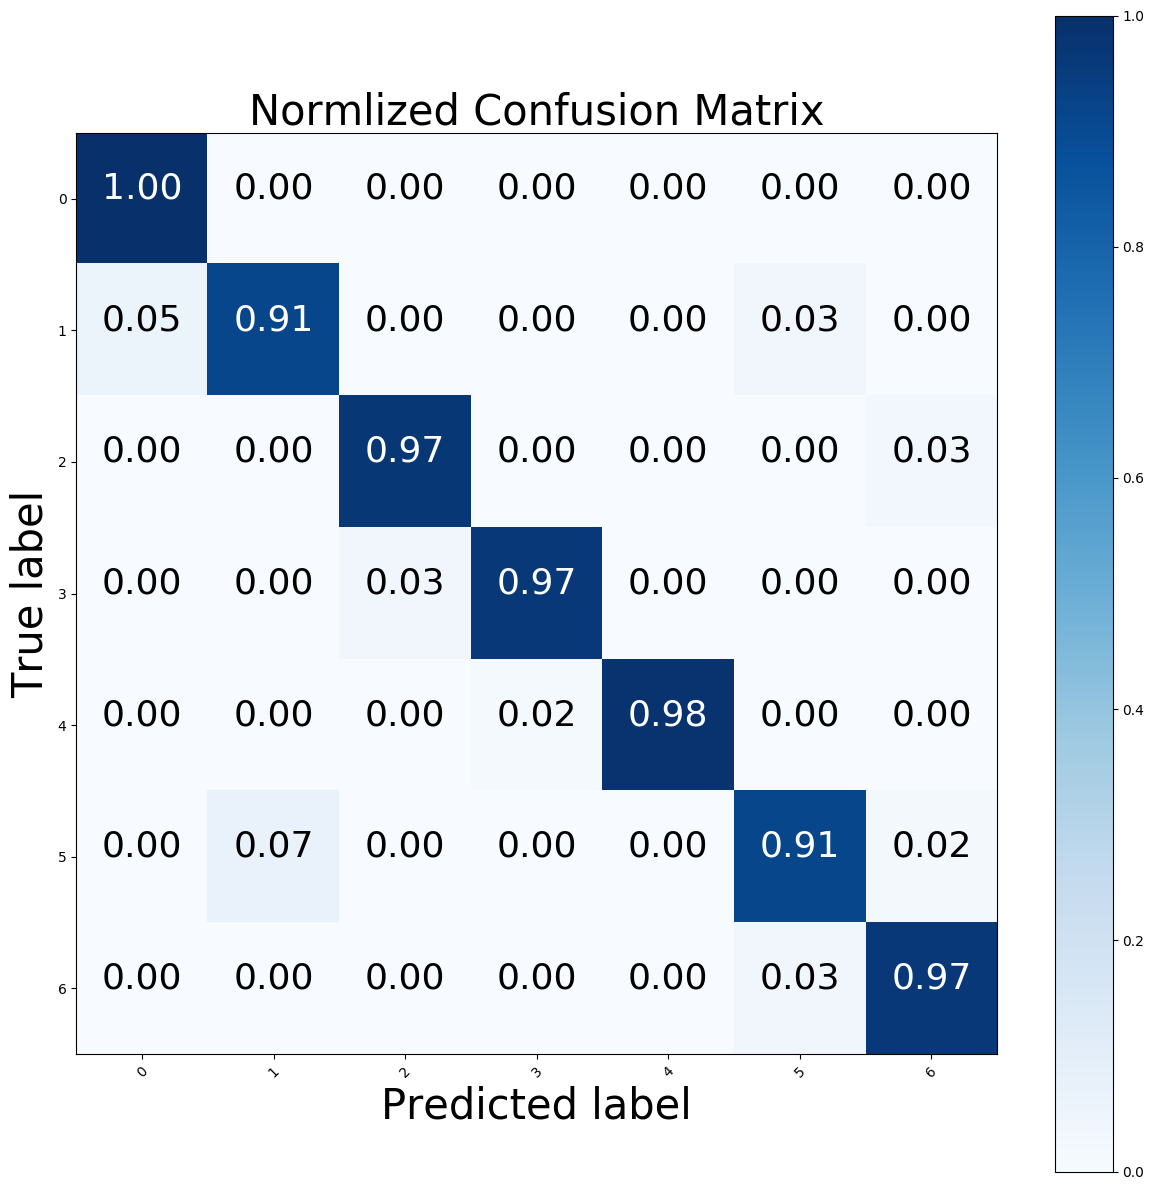

In [26]:
plt.close()
plt.figure(figsize=(12, 12))
plt.imshow(normed_confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title('Normlized Confusion Matrix', fontsize=30)
plt.colorbar()
tick_marks = np.arange(len(num_classes))
plt.xticks(tick_marks, num_classes, rotation=45)
plt.yticks(tick_marks, num_classes)
plt.tight_layout()

fmt = '.2f'
thresh = confusion_matrix.max() / 2.0
for i, j in itertools.product(range(normed_confusion_matrix.shape[0]), range(normed_confusion_matrix.shape[1])):
    plt.text(j, i, format(normed_confusion_matrix[i, j], fmt),
             horizontalalignment="center",
             color='white' if confusion_matrix[i, j] > thresh else "black",
            size=26)

plt.tight_layout()
plt.ylabel('True label', fontsize=30)
plt.xlabel('Predicted label', fontsize=30)

# Learning Curve

In [38]:
train_sizes = np.append(np.linspace(0.05, 0.1, 20, endpoint=False),
                            np.linspace(0.1, 1, 20, endpoint=True))

# calculate

# balanced accuracy
# balanced_accuracy_train_sizes, balanced_accuracy_train_scores, balanced_accuracy_test_scores = sklearn.model_selection.learning_curve(
#     best_estimator,
#     training_x,
#     training_y,
#     cv=5,
#     train_sizes=train_sizes,
#     verbose=10,
#     scoring=make_scorer(balanced_accuracy),
#     n_jobs=4,
#     random_state=seed)


# unbalanced accuracy
accuracy_train_sizes, accuracy_train_scores, accuracy_test_scores = sklearn.model_selection.learning_curve(
    best_estimator,
    training_x,
    training_y,
    cv=5,
    train_sizes=train_sizes,
    verbose=10,
    scoring=make_scorer(accuracy_score),
    n_jobs=4,
    random_state=seed)

# precision
# precision_train_sizes, precision_train_scores, precision_test_scores = sklearn.model_selection.learning_curve(
#     best_estimator,
#     training_x,
#     training_y,
#     cv=5,
#     train_sizes=train_sizes,
#     verbose=10,
#     scoring=make_scorer(precision_score),
#     n_jobs=4,
#     random_state=seed)

# # recall
# recall_train_sizes, recall_train_scores, recall_test_scores = sklearn.model_selection.learning_curve(
#     best_estimator,
#     training_x,
#     training_y,
#     cv=5,
#     train_sizes=train_sizes,
#     verbose=10,
#     scoring=make_scorer(recall_score),
#     n_jobs=4,
#     random_state=seed)

# # roc_auc accuracy
# roc_auc_train_sizes, roc_auc_train_scores, roc_auc_test_scores = sklearn.model_selection.learning_curve(
#     best_estimator,
#     training_x,
#     training_y,
#     cv=5,
#     train_sizes=train_sizes,
#     verbose=10,
#     scoring=make_scorer(roc_auc_score),
#     n_jobs=4,
#     random_state=seed)




[learning_curve] Training set sizes: [  67   70   74   77   80   84   87   90   94   97  101  104  107  111
  114  117  121  124  127  131  134  198  262  326  389  453  517  581
  645  708  772  836  900  964 1027 1091 1155 1219 1283 1347]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....................... , score=0.5190615835777126, total=   0.1s
[CV]  ................................................................


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....................... , score=0.5513196480938416, total=   0.2s
[CV]  ................................................................


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ........................ , score=0.592375366568915, total=   0.2s
[CV]  ................................................................


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....................... , score=0.5571847507331378, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.5806451612903226, total=   0.2s
[CV]  ................................................................
[CV] ........................ , score=0.624633431085044, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.6158357771260997, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.5953079178885631, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.6070381231671554, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.6217008797653959, total=   0.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done  12 out of 200 | elapsed:    0.7s remaining:   10.9s


[CV] ....................... , score=0.6392961876832844, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.6598240469208211, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.6627565982404692, total=   0.2s[CV] ....................... , score=0.6920821114369502, total=   0.2s

[CV]  ................................................................[CV]  ................................................................

[CV] ....................... , score=0.6334310850439883, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.7771260997067448, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.8093841642228738, total=   0.4s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done  33 out of 200 | elapsed:    3.3s remaining:   16.6s


[CV] ........................ , score=0.967741935483871, total=   0.8s
[CV]  ................................................................
[CV] ....................... , score=0.9413489736070382, total=   0.9s
[CV]  ................................................................
[CV] ....................... , score=0.9530791788856305, total=   1.0s
[CV]  ................................................................
[CV] ....................... , score=0.9618768328445748, total=   0.8s
[CV]  ................................................................
[CV] ....................... , score=0.9648093841642229, total=   1.1s
[CV]  ................................................................
[CV] ....................... , score=0.5676470588235294, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.5735294117647058, total=   0.1s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done  54 out of 200 | elapsed:    5.5s remaining:   14.8s


[CV] ....................... , score=0.7147058823529412, total=   0.2s
[CV]  ................................................................
[CV] ..................................... , score=0.65, total=   0.2s
[CV]  ................................................................
[CV] ........................ , score=0.711764705882353, total=   0.1s
[CV]  ................................................................
[CV] ...................................... , score=0.8, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.8588235294117647, total=   0.3s
[CV]  ................................................................
[CV] ....................... , score=0.8470588235294118, total=   0.4s
[CV]  ................................................................
[CV] ....................... , score=0.8764705882352941, total=   0.4s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done  75 out of 200 | elapsed:    8.9s remaining:   14.8s


[CV] ....................... , score=0.9117647058823529, total=   0.9s
[CV]  ................................................................
[CV] ....................... , score=0.5370919881305638, total=   0.2s
[CV] ....................... , score=0.9382352941176471, total=   1.2s
[CV]  ................................................................[CV]  ................................................................

[CV] ....................... , score=0.5459940652818991, total=   0.1s[CV] ....................... , score=0.5845697329376854, total=   0.2s

[CV]  ................................................................
[CV]  ................................................................
[CV] ........................ , score=0.543026706231454, total=   0.1s
[CV]  ................................................................
[CV] ....................... , score=0.5400593471810089, total=   0.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done  96 out of 200 | elapsed:   10.6s remaining:   11.5s



[CV] ....................... , score=0.6498516320474778, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.8071216617210683, total=   0.3s
[CV]  ................................................................
[CV] ....................... , score=0.8724035608308606, total=   0.3s
[CV]  ................................................................
[CV] ....................... , score=0.8902077151335311, total=   0.4s
[CV]  ................................................................
[CV] ....................... , score=0.8813056379821959, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9109792284866469, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9169139465875371, total=   0.6s
[CV]  ................................................................
[CV] 

[Parallel(n_jobs=4)]: Done 117 out of 200 | elapsed:   13.9s remaining:    9.9s


[CV] ....................... , score=0.5744047619047619, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.5892857142857143, total=   0.1s
[CV]  ................................................................[CV] ....................... , score=0.5922619047619048, total=   0.1s

[CV]  ................................................................
[CV] ....................... , score=0.9436201780415431, total=   1.1s
[CV]  ................................................................
[CV] ....................... , score=0.5595238095238095, total=   0.1s
[CV] ....................... , score=0.6130952380952381, total=   0.2s[CV]  ................................................................

[CV]  ................................................................
[CV] ....................... , score=0.6130952380952381, total=   0.1s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done 138 out of 200 | elapsed:   15.6s remaining:    7.0s


[CV] ....................... , score=0.8095238095238095, total=   0.3s
[CV]  ................................................................
[CV] ....................... , score=0.8660714285714286, total=   0.4s
[CV]  ................................................................
[CV] ....................... , score=0.8809523809523809, total=   0.4s
[CV]  ................................................................
[CV] ....................... , score=0.8958333333333334, total=   0.4s
[CV]  ................................................................
[CV] ....................... , score=0.9404761904761905, total=   0.7s
[CV]  ................................................................
[CV] ....................... , score=0.9315476190476191, total=   0.7s
[CV]  ................................................................[CV] ....................... , score=0.9255952380952381, total=   0.7s

[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done 159 out of 200 | elapsed:   19.5s remaining:    5.0s


[CV] ........................ , score=0.562874251497006, total=   0.1s
[CV]  ................................................................
[CV] ....................... , score=0.5329341317365269, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.9642857142857143, total=   1.3s
[CV]  ................................................................[CV] ....................... , score=0.5508982035928144, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.6077844311377245, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.6227544910179641, total=   0.2s[CV] ....................... , score=0.6317365269461078, total=   0.1s

[CV]  ................................................................[CV]  ................................................................

[CV] ..

[Parallel(n_jobs=4)]: Done 180 out of 200 | elapsed:   20.8s remaining:    2.3s


[CV] ....................... , score=0.8892215568862275, total=   0.3s
[CV] ....................... , score=0.8862275449101796, total=   0.3s[CV]  ................................................................

[CV]  ................................................................
[CV] ....................... , score=0.8772455089820359, total=   0.3s
[CV]  ................................................................
[CV] ....................... , score=0.9281437125748503, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9161676646706587, total=   0.6s
[CV]  ................................................................
[CV] ....................... , score=0.9281437125748503, total=   0.6s
[CV]  ................................................................
[CV] ....................... , score=0.9131736526946108, total=   0.7s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   25.5s finished


In [39]:
# # plot
# plt.close()
# plt.figure(figsize=(12, 12))
# plt.title('Balanced Accuracy Learning Curve', fontsize=35)

# plt.xlabel('Training examples (count)', fontsize=30)
# plt.ylabel('Balanced Accuracy (0.0 - 1.0)', fontsize=30)
# plt.grid()
# plt.tight_layout()

# train_scores = balanced_accuracy_train_scores
# test_scores = balanced_accuracy_test_scores
# train_sizes = balanced_accuracy_train_sizes

# train_points = train_scores
# test_points = test_scores

# ax = plt.gca()
# ax.set_xscale("linear")
# ax.set_yscale("linear")

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# train_points = train_scores_mean
# test_points = test_scores_mean

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2)

# plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
#          label="Training score")
# plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
#          label="Cross-validation score")

# plt.legend(loc="best")

# # ---------------------------------------------------------------


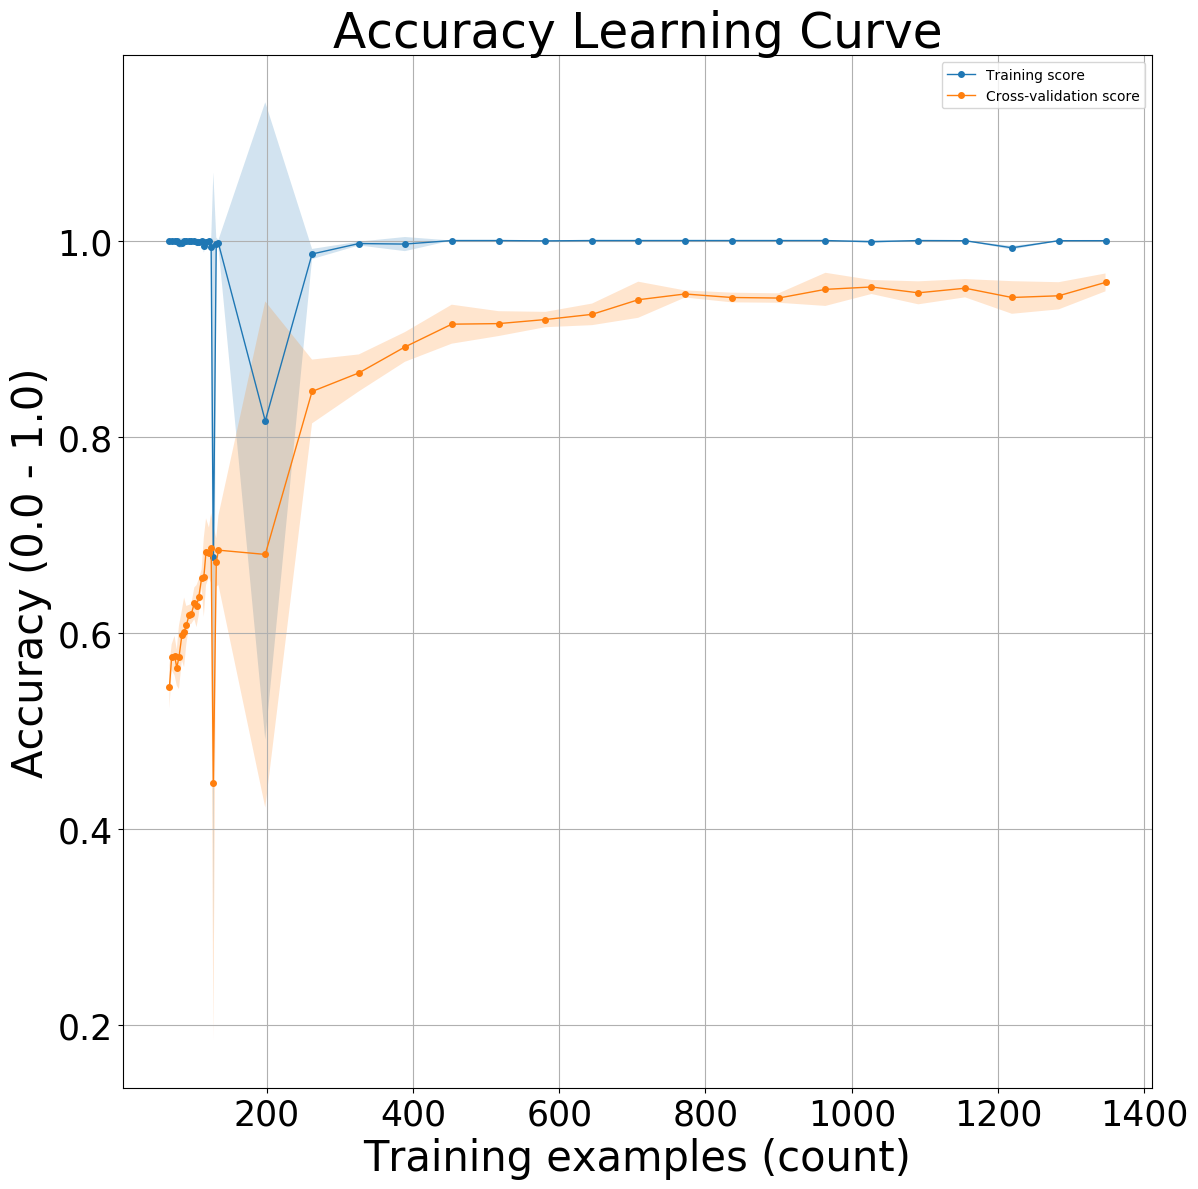

In [40]:
plt.close()
plt.figure(figsize=(12, 12))
plt.tick_params(labelsize=25)

plt.title('Accuracy Learning Curve', fontsize=35)

plt.xlabel('Training examples (count)', fontsize=30)
plt.ylabel('Accuracy (0.0 - 1.0)', fontsize=30)
plt.grid()
plt.tight_layout()

train_scores = accuracy_train_scores
test_scores = accuracy_test_scores
train_sizes = accuracy_train_sizes

train_points = train_scores
test_points = test_scores

ax = plt.gca()
ax.set_xscale("linear")
ax.set_yscale("linear")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
train_points = train_scores_mean
test_points = test_scores_mean

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2)

plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
         label="Training score")
plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
         label="Cross-validation score")

plt.legend(loc="best")



# ---------------------------------------------------------------
# ---------------------------------------------------------------


In [67]:
print(train_sizes)
print(train_scores_mean)
print(test_scores_mean)

[100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[0.14705066 0.13847371 0.59363144 0.98488796 0.99970315 0.86315415
 0.29590703 0.14574518]
[0.14698912 0.13923658 0.58759086 0.9153097  0.95438758 0.84768828
 0.29802485 0.14863467]


In [41]:
# plt.close()
# plt.figure(figsize=(12, 12))
# plt.title('Precision Learning Curve')

# plt.xlabel('Training examples (count)')
# plt.ylabel('Accuracy (0.0 - 1.0)')
# plt.grid()
# plt.tight_layout()

# train_scores = precision_train_scores
# test_scores = precision_test_scores
# train_sizes = precision_train_sizes

# train_points = train_scores
# test_points = test_scores

# ax = plt.gca()
# ax.set_xscale("linear")
# ax.set_yscale("linear")

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# train_points = train_scores_mean
# test_points = test_scores_mean

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2)

# plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
#          label="Training score")
# plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
#          label="Cross-validation score")

# plt.legend(loc="best")

# # -------------------------------------------


In [42]:
# plt.close()
# plt.figure(figsize=(12, 12))

# plt.title('Recall Accuracy Learning Curve')

# plt.xlabel('Training examples (count)')
# plt.ylabel('Accuracy (0.0 - 1.0)')
# plt.grid()
# plt.tight_layout()

# train_scores = recall_train_scores
# test_scores = recall_test_scores
# train_sizes = recall_train_sizes

# train_points = train_scores
# test_points = test_scores

# ax = plt.gca()
# ax.set_xscale("linear")
# ax.set_yscale("linear")

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# train_points = train_scores_mean
# test_points = test_scores_mean

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2)

# plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
#          label="Training score")
# plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
#          label="Cross-validation score")

# plt.legend(loc="best")


# # -------------------------------------------


In [43]:
# plt.close()
# plt.figure(figsize=(12, 12))
# plt.title('ROC-AUC Accuracy Learning Curve')
# plt.xlabel('Training examples (count)')
# plt.ylabel('Accuracy (0.0 - 1.0)')
# plt.grid()
# plt.tight_layout()

# train_scores = roc_auc_train_scores
# test_scores = roc_auc_test_scores
# train_sizes = roc_auc_train_sizes

# train_points = train_scores
# test_points = test_scores

# ax = plt.gca()
# ax.set_xscale("linear")
# ax.set_yscale("linear")

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# train_points = train_scores_mean
# test_points = test_scores_mean

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2)

# plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
#          label="Training score")
# plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
#          label="Cross-validation score")

# plt.legend(loc="best")

No handles with labels found to put in legend.


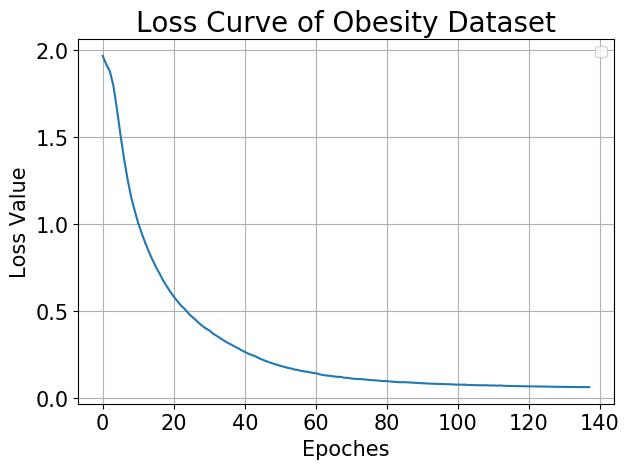

In [65]:
# loss_values = best_estimator.loss_curve_
best_estimator
best_estimator.fit(training_x, training_y)

learning_rate_init_adjust = [10 ** -x for x in np.arange(-2.0, 6.0)]


plt.show()


plt.close('all')
plt.figure()
plt.title('Loss Curve of Obesity Dataset', fontsize=20)
plt.tick_params(labelsize=15)

plt.xlabel('Epoches', fontsize=15)
plt.ylabel('Loss Value', fontsize=15)
plt.grid()
plt.tight_layout()

plt.plot(loss_values, label="")

plt.legend(loc="best")
plt.tight_layout()

training: learning-rate-0.1
Training set score: 0.987559
Training set loss: 0.114389
training: learning-rate-0.01
Training set score: 0.998815
Training set loss: 0.066562
training: learning-rate-0.001
Training set score: 0.866706
Training set loss: 0.619261
training: learning-rate-0.0001
Training set score: 0.174763
Training set loss: 1.904599
training: learning-rate-0.00001
Training set score: 0.140403
Training set loss: 1.978471
training: learning-rate-0.000001
Training set score: 0.129147
Training set loss: 1.988615
training: learning-rate-1.0
Training set score: 0.653436
Training set loss: 1.163575
training: learning-rate-10.0
Training set score: 0.153436
Training set loss: 23.106232
learning-rate-0.1
learning-rate-0.01
learning-rate-0.001
learning-rate-0.0001
learning-rate-0.00001
learning-rate-0.000001
learning-rate-1.0


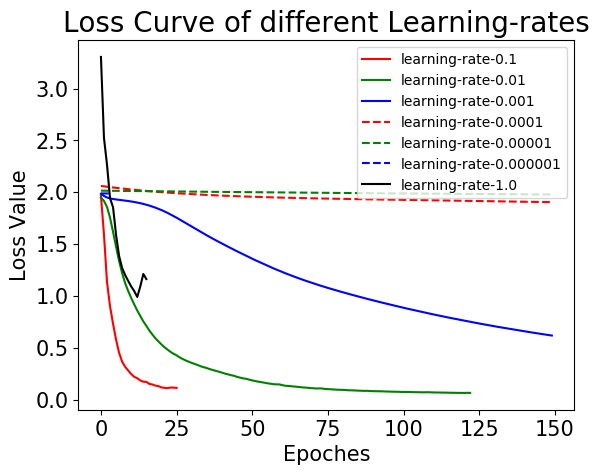

In [66]:
import warnings

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

# different learning rate schedules and momentum parameters

labels = [
    "learning-rate-0.1",
    "learning-rate-0.01",
        "learning-rate-0.001",
        "learning-rate-0.0001",
        "learning-rate-0.00001",
        "learning-rate-0.000001",
        "learning-rate-1.0",
        "learning-rate-10.0",
]

plot_args = [
    {"c": "red", "linestyle": "-"},
    {"c": "green", "linestyle": "-"},
    {"c": "blue", "linestyle": "-"},
    {"c": "red", "linestyle": "--"},
    {"c": "green", "linestyle": "--"},
    {"c": "blue", "linestyle": "--"},
    {"c": "black", "linestyle": "-"},
]

learning_rate_init_adjust = [10 ** -x for x in np.arange(-2.0, 6.0)]
# The best parameters are: MLPClassifier(activation='logistic', alpha=0.01, batch_size='auto',
#        beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=(16, 16), learning_rate='constant',
#        learning_rate_init=0.01, max_iter=200, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=None,
#        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
#        verbose=False, warm_start=False)
    
params = [
    {
        "solver":'adam',
        "learning_rate": "constant",
        "momentum": 0.9,
        "learning_rate_init": 0.1,
        "hidden_layer_sizes": (16,16),
        "tol": 0.0001,
        "alpha": 0.01, "activation": 'logistic'
    },
      {
        "solver":'adam',
        "learning_rate": "constant",
        "momentum": 0.9,
        "learning_rate_init": 0.01,
        "hidden_layer_sizes": (16,16),
        "tol": 0.0001,
        "alpha": 0.01, "activation": 'logistic'
    },
        {
        "solver":'adam',
        "learning_rate": "constant",
        "momentum": 0.9,
        "learning_rate_init": 0.001,
        "hidden_layer_sizes": (16,16),
        "tol": 0.0001,
        "alpha": 0.01, "activation": 'logistic'
    },
        {
        "solver":'adam',
        "learning_rate": "constant",
        "momentum": 0.9,
        "learning_rate_init": 0.0001,
        "hidden_layer_sizes": (16,16),
        "tol": 0.0001,
        "alpha": 0.01, "activation": 'logistic'
    },
        {
        "solver":'adam',
        "learning_rate": "constant",
        "momentum": 0.9,
        "learning_rate_init": 0.00001,
        "hidden_layer_sizes": (16,16),
        "tol": 0.0001,
        "alpha": 0.01, "activation": 'logistic'
    },
        {
        "solver":'adam',
        "learning_rate": "constant",
        "momentum": 0.9,
        "learning_rate_init": 0.000001,
        "hidden_layer_sizes": (16,16),
        "tol": 0.0001,
        "alpha": 0.01, "activation": 'logistic'
    },
        {
        "solver":'adam',
        "learning_rate": "constant",
        "momentum": 0.9,
        "learning_rate_init": 1.0,
        "hidden_layer_sizes": (16,16),
        "tol": 0.0001,
        "alpha": 0.01, "activation": 'logistic'
    },
        {
        "solver":'adam',
        "learning_rate": "constant",
        "momentum": 0.9,
        "learning_rate_init": 10.0,
        "hidden_layer_sizes": (16,16),
        "tol": 0.0001,
        "alpha": 0.01, "activation": 'logistic'
    },
]



    # for each dataset, plot learning for each learning strategy

mlps = []

plt.close('all')
plt.figure()
plt.title('Loss Curve of different Learning-rates', fontsize=20)
plt.tick_params(labelsize=15)

plt.xlabel('Epoches', fontsize=15)
plt.ylabel('Loss Value', fontsize=15)

max_iter = 150
for label, param in zip(labels, params):
    print("training: %s" % label)
    mlp = MLPClassifier(max_iter=max_iter, **param)
    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", category=ConvergenceWarning, module="sklearn"
        )
        mlp.fit(training_x,training_y)
    mlps.append(mlp)
    print("Training set score: %f" % mlp.score(training_x, training_y))
    print("Training set loss: %f" % mlp.loss_)
for mlp, label, args in zip(mlps, labels, plot_args):
    print(label)
    plt.plot(mlp.loss_curve_, label=label, **args)
plt.legend(loc="best")

plt.show()

# Compelxity Param: Learning Rate

In [44]:
# balanced_accuracy_train_scores, balanced_accuracy_test_scores = sklearn.model_selection.validation_curve(best_estimator,training_x, training_y, "alpha", alphas, cv=5,
#                                                  scoring=data1_scorer, n_jobs=4)
learning_rate_init_adjust = [10 ** -x for x in np.arange(-2.0, 6.0)]


accuracy_train_scores, accuracy_test_scores = sklearn.model_selection.validation_curve(best_estimator,training_x, training_y, "learning_rate_init", learning_rate_init_adjust, cv=5,
                                                 scoring=make_scorer(accuracy_score), n_jobs=4)

# precision_train_scores, precision_test_scores = sklearn.model_selection.validation_curve(best_estimator,training_x, training_y, "alpha", alphas, cv=5,
#                                                  scoring=make_scorer(precision_score), n_jobs=4)

# recall_train_scores, recall_test_scores = sklearn.model_selection.validation_curve(best_estimator,training_x, training_y, "alpha", alphas, cv=5,
#                                                  scoring=make_scorer(recall_score), n_jobs=4)

# roc_auc_train_scores, roc_auc_test_scores = sklearn.model_selection.validation_curve(best_estimator,training_x, training_y, "alpha", alphas, cv=5,
#                                                  scoring=make_scorer(roc_auc_score), n_jobs=4)

/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Max

In [45]:
# plt.close('all')
# plt.figure()
# plt.title('Model Complexity Curve: Alpha')

# plt.xlabel('Training examples (count)')
# plt.ylabel('Accuracy (0.0 - 1.0)')
# plt.grid()
# plt.tight_layout()

# train_scores = balanced_accuracy_train_scores
# test_scores = balanced_accuracy_test_scores
# train_sizes = alphas

# train_points = train_scores
# test_points = test_scores
# ax = plt.gca()
# x_scale = 'log'
# y_scale = 'linear'

# ax.set_xscale(x_scale)
# ax.set_yscale(y_scale)

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# train_points = train_scores_mean
# test_points = test_scores_mean

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.2)

# plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
#      label="Training score")
# plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
#      label="Cross-validation score")

# plt.legend(loc="best")
# plt.tight_layout()

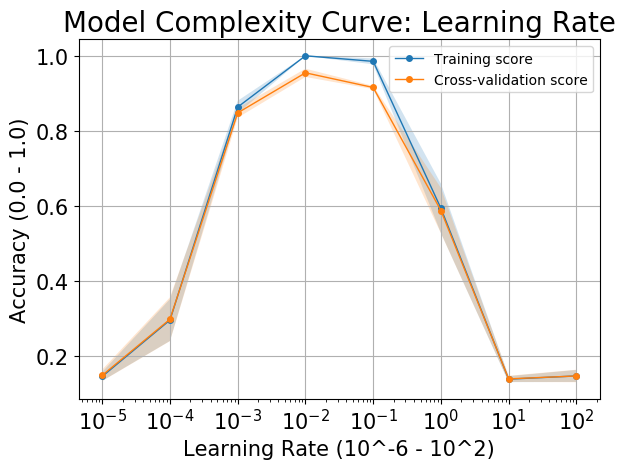

In [46]:
plt.close('all')
plt.figure()
plt.tick_params(labelsize=15)

plt.title('Model Complexity Curve: Learning Rate', fontsize=20)

plt.xlabel('Learning Rate (10^-6 - 10^2)', fontsize=15)
plt.ylabel('Accuracy (0.0 - 1.0)', fontsize=15)
plt.grid()
plt.tight_layout()

train_scores = accuracy_train_scores
test_scores = accuracy_test_scores
train_sizes = learning_rate_init_adjust


train_points = train_scores
test_points = test_scores
ax = plt.gca()
x_scale = 'log'
y_scale = 'linear'

ax.set_xscale(x_scale)
ax.set_yscale(y_scale)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
train_points = train_scores_mean
test_points = test_scores_mean

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2)

plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
     label="Training score")
plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
     label="Cross-validation score")

plt.legend(loc="best")
plt.tight_layout()

In [47]:
# plt.close('all')
# plt.figure()
# plt.title('Model Complexity Curve: Alpha')

# plt.xlabel('Training examples (count)')
# plt.ylabel('Accuracy (0.0 - 1.0)')
# plt.grid()
# plt.tight_layout()

# train_scores = precision_train_scores
# test_scores = precision_test_scores
# train_sizes = alphas

# train_points = train_scores
# test_points = test_scores
# ax = plt.gca()
# x_scale = 'log'
# y_scale = 'linear'

# ax.set_xscale(x_scale)
# ax.set_yscale(y_scale)

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# train_points = train_scores_mean
# test_points = test_scores_mean

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.2)

# plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
#      label="Training score")
# plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
#      label="Cross-validation score")

# plt.legend(loc="best")
# plt.tight_layout()


In [48]:
# plt.close('all')
# plt.figure()
# plt.title('Model Complexity Curve: Alpha')

# plt.xlabel('Training examples (count)')
# plt.ylabel('Accuracy (0.0 - 1.0)')
# plt.grid()
# plt.tight_layout()

# train_scores = recall_train_scores
# test_scores = recall_test_scores
# train_sizes = alphas

# train_points = train_scores
# test_points = test_scores
# ax = plt.gca()
# x_scale = 'log'
# y_scale = 'linear'

# ax.set_xscale(x_scale)
# ax.set_yscale(y_scale)

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# train_points = train_scores_mean
# test_points = test_scores_mean

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.2)

# plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
#      label="Training score")
# plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
#      label="Cross-validation score")

# plt.legend(loc="best")
# plt.tight_layout()


In [49]:
# plt.close('all')
# plt.figure()
# plt.title('Model Complexity Curve: Alpha')

# plt.xlabel('Training examples (count)')
# plt.ylabel('Accuracy (0.0 - 1.0)')
# plt.grid()
# plt.tight_layout()

# train_scores = roc_auc_train_scores
# test_scores = roc_auc_test_scores
# train_sizes = alphas

# train_points = train_scores
# test_points = test_scores
# ax = plt.gca()
# x_scale = 'log'
# y_scale = 'linear'

# ax.set_xscale(x_scale)
# ax.set_yscale(y_scale)

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# train_points = train_scores_mean
# test_points = test_scores_mean

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.2)

# plt.plot(train_sizes, train_points, 'o-', linewidth=1, markersize=4,
#      label="Training score")
# plt.plot(train_sizes, test_points, 'o-', linewidth=1, markersize=4,
#      label="Cross-validation score")

# plt.legend(loc="best")
# plt.tight_layout()


# Timing Curve

In [68]:
from time import clock


sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tests = 5
out = dict()
out['train'] = np.zeros(shape=(len(sizes), tests))
out['test'] = np.zeros(shape=(len(sizes), tests))

for i, frac in enumerate(sizes):
    for j in range(tests):
        np.random.seed(seed)
        x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(training_x, training_y, test_size=1 - frac, random_state=seed)
        st = clock()
        best_estimator.fit(x_train, y_train)
        out['train'][i, j] = (clock() - st)
        st = clock()
        best_estimator.predict(x_test)
        out['test'][i, j] = (clock() - st)


/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/shari/miniconda3/envs/shari_hw_ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or t

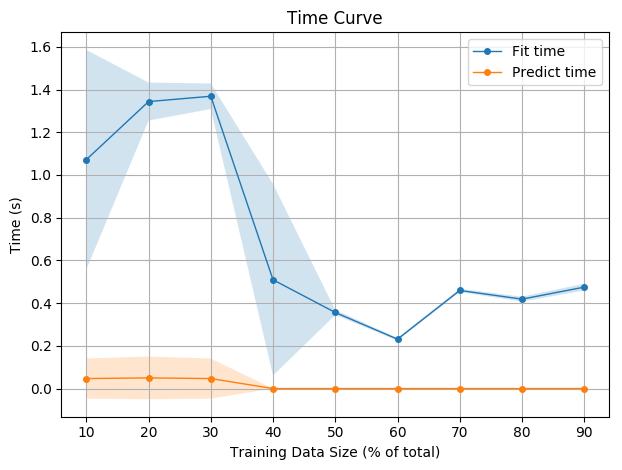

In [69]:
plt.close()
plt.figure()
plt.title("Time Curve")

plt.xlabel("Training Data Size (% of total)")
plt.ylabel("Time (s)")
fit_scores_mean = np.mean(out['train'], axis=1)
fit_scores_std = np.std(out['train'], axis=1)
predict_scores_mean = np.mean(out['test'], axis=1)
predict_scores_std = np.std(out['test'], axis=1)
plt.grid()
plt.tight_layout()

plt.fill_between(np.array(sizes) * 100, fit_scores_mean - fit_scores_std,
                 fit_scores_mean + fit_scores_std, alpha=0.2)
plt.fill_between(np.array(sizes) * 100, predict_scores_mean - predict_scores_std,
                 predict_scores_mean + predict_scores_std, alpha=0.2)
plt.plot(np.array(sizes) * 100, fit_scores_mean, 'o-', linewidth=1, markersize=4,
         label="Fit time")
plt.plot(np.array(sizes) * 100, predict_scores_mean, 'o-', linewidth=1, markersize=4,
         label="Predict time")

plt.legend(loc="best")

In [70]:
print(fit_scores_mean)
print(predict_scores_mean)


[1.071875 1.34375  1.36875  0.509375 0.35625  0.23125  0.459375 0.41875
 0.475   ]
[0.046875 0.05     0.046875 0.       0.       0.       0.       0.
 0.      ]
